# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
from datetime import datetime
import seaborn as sns
from typing import *
import scipy.stats as scistat
from scipy import special
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine
import pymysql

# **Importing Dataset**

In [2]:
# MySQL connection details
host='localhost'
user='Tvan'
password='Tvan217desu~'
database='personal_finance'

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")  #<- Create engine for MySQL connection

query = "SELECT * FROM dummy_transactions"                                      #<- SQL query to fetch data from transactions table
df = pd.read_sql(query, con=engine)                                             #<- Read data into a DataFrame

df

,trans_no,date,details,amount,transaction,transaction_mode
0,1,2023-09-14,サラリー,17732,Income,Bank
1,2,2023-10-09,サラリー,12754,Income,Bank
2,3,2023-10-15,bank withdraw,26142,Withdraw,Bank
3,4,2023-10-15,stash deposit,26142,Deposit,Stash
4,5,2023-10-31,サラリー,12834,Income,Bank
...,...,...,...,...,...,...
666,667,2025-01-24,pamahaw,392,Expenses,Stash
667,668,2025-01-24,paperworld,58,Expenses,Stash
668,669,2025-01-24,photocopy,18,Expenses,Stash
669,670,2025-01-24,pahahe,20,Expenses,Stash


# **Data Cleaning**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   trans_no          671 non-null    int64 
 1   date              671 non-null    object
 2   details           671 non-null    object
 3   amount            671 non-null    int64 
 4   transaction       671 non-null    object
 5   transaction_mode  671 non-null    object
dtypes: int64(2), object(4)
memory usage: 31.6+ KB


In [4]:
# Converting `date` column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')      #<- Convert `date` column to datetime format

# Appending `year`, `month`, and `day` data from the dataset
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['year'] = df['date'].dt.year

# Creating and Appending str date data
ymd = []                                                        #<- `ymd` means year, month, and day (YY/MM/DD)
ym = []                                                         #<- `ym` means year and month (YY/MM)

# Editing and Adding New Column Entry (Extracting Data)
detail_clean = []
for i, detail in df.iterrows():
    ym.append(f"{str(detail['year'])[2:]}/{detail['month']}")                   #<- Appending `YY/MM`
    ymd.append(f"{str(detail['year'])[2:]}/{detail['month']}/{detail['day']}")  #<- Appending `YY/MM/DD`

    detail_lower = detail['details'].lower()                    #<- Convert details to lowercase for uniformity
    if detail_lower == 'supa':                                  #<- Check if detail is 'supa'       
        detail_clean.append('Supa')
    elif detail_lower[:len('steam')] == 'steam':                #<- Check if detail starts with 'steam'
        detail_clean.append('Steam')
    elif detail_lower[:len('aragmot')] == 'aragmot':            #<- Check if detail starts with 'aragmot'
        detail_clean.append('Aragmot')
    elif detail_lower[:len('gcash cash-out')] == 'gcash cash-out':  #<- Check if detail starts with 'gcash cash-out'
        detail_clean.append('Gcash cash-out')
    elif detail_lower[-len('cash-in'):] == 'cash-in' or detail_lower[:len('gcash')] == 'gcash': #<- Check if detail ends with 'cash-in' or starts with 'gcash'
        detail_clean.append('Gcash cash-in')
    else:
        detail_clean.append(detail['details'])

df['detail_clean'] = detail_clean                               #<- Appending cleaned details to the DataFrame
df['y/m'] = ym                                                  #<- Appending Year/Month (YY/MM) to the DataFrame
df['y/m/d'] = ymd                                               #<- Appending Year/Month/Day (YY/MM/DD) to the DataFrame 

# Date Sorting No. (from earlier to current date)
date_arrangement = {}                                           #<- Dictionary to hold date arrangements for sorting
for i, date in enumerate(df['y/m'].unique().tolist()):          #<- Enumerate through unique dates in 'y/m' column
    date_arrangement[date] = i                                  

df['month sort no.'] = df['y/m'].map(date_arrangement)          #<- Appending Date Sorting No.

df

,trans_no,date,details,amount,transaction,transaction_mode,month,day,year,detail_clean,y/m,y/m/d,month sort no.
0,1,2023-09-14,サラリー,17732,Income,Bank,9,14,2023,サラリー,23/9,23/9/14,0
1,2,2023-10-09,サラリー,12754,Income,Bank,10,9,2023,サラリー,23/10,23/10/9,1
2,3,2023-10-15,bank withdraw,26142,Withdraw,Bank,10,15,2023,bank withdraw,23/10,23/10/15,1
3,4,2023-10-15,stash deposit,26142,Deposit,Stash,10,15,2023,stash deposit,23/10,23/10/15,1
4,5,2023-10-31,サラリー,12834,Income,Bank,10,31,2023,サラリー,23/10,23/10/31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,667,2025-01-24,pamahaw,392,Expenses,Stash,1,24,2025,pamahaw,25/1,25/1/24,16
667,668,2025-01-24,paperworld,58,Expenses,Stash,1,24,2025,paperworld,25/1,25/1/24,16
668,669,2025-01-24,photocopy,18,Expenses,Stash,1,24,2025,photocopy,25/1,25/1/24,16
669,670,2025-01-24,pahahe,20,Expenses,Stash,1,24,2025,pahahe,25/1,25/1/24,16


# **Class and Functional Programming**

In [5]:
# Class Programming for Calc and Printing Mean and Standard Deviation
class StatsSummary:
    """Prints statistic summary (*mean*, *std*, *median*)
    
    ### **Parameter:**
    `data`
    - `DataFrame`, `dict`, or `array` type
    - the data to get its statistic summary
    -----------
    ### **Methods**
    - **`print_stats()`**
        - prints statistic summary
    - **`<class var>.data`**
        - get data
    - **`<class var>.mean`**
        - get mean of data
    - **`<class var>.median`**
        - get median of data
    - **`<class var>.std`**
        - get standard deviation of data
    - **`<class var>.stats`**
        - get dictionary of statistic summary"""

    def __init__(self, data) -> None:                       #<- Instantiation
        self.data = data                                    #<- Data
        self.stat_summary = data.describe()                 #<- Count, mean, std, min, 25%, 50%, 75%, max
        self.mean = np.mean(data)                           #<- Mean
        self.median = np.median(data)                       #<- Median
        self.std = np.std(data, ddof=1)                     #<- Std (1 degree of freedom)
        self.mad = scistat.median_abs_deviation(data)       #<- Median Absolute Deviation
        self.skew = scistat.skew(data)                      #<- Skewness
        self.kurtosis = scistat.kurtosis(data, fisher=True)  #<- Kurtosis (Fisher's definition)
        self.stats: dict = {'Mean': self.mean,              #<- Dictionary for statistics summary
                            'Standard Deviation': self.std, 
                            'Median': self.median,
                            'MAD': self.mad,
                            'Skewness': self.skew,
                            'Kurtosis': self.kurtosis,
                            'Mean-Median Gap': np.abs(self.mean - self.median) / self.mean}
    

    def print_stats(self, mean: bool=True, std: bool=True, 
                    median: bool=False, mad: bool=False, skew: bool=True, 
                    kurtosis: bool=True, mean_median_gap: bool=True, round_digit:int = False) -> None:
        """Prints statistic summary.
        - Mean
        - Standard Deviation
        - Median
        - Median Absolute Deviation (MAD)
        - Skewness"""
        
        stats = {'Mean': mean, 'Standard Deviation': std, 'Median': median, 
                 'MAD': mad, 'Skewness': skew, 'Kurtosis': kurtosis, 'Mean-Median Gap': mean_median_gap}     #<- Dict for mean, std, and mean param checking

        for stat_key, stat in stats.items():                                    #<- Iter "stats" dict
            if stat:                                                            #<- Checks if mean, std, median param are true
                if type(round_digit) == int or round_digit == True :            #<- Checks "round_digit" type if int or it is True

                    if type(round_digit) != int:
                        print('WARNING!: `round_digit` must be an int not bool. Setting `round_digit` to 0.\n') #<- Warning message 
                        round_digit = 0                                                     #<- Setting to 0 since "True" can't mathematically operatable

                    print(f"{stat_key} = {np.round(self.stats[stat_key], round_digit):,}")    #<- Prints rounded value
                else:
                    print(f"{stat_key} = {self.stats[stat_key]:,}")                           #<- Prints value as is

    
def plot_line_bar(dataset: pd.DataFrame, x:str, y:str, plot_title: str|list, fig_size:tuple=(10, 6)) -> None:
    """## **Function:**
    - Plotting line and bar graphs using `sns.lineplot()` and `sns.barplot()` in subplots.
    ---------
    ## **Parameters:**
    - `dataset=`
        - `pd.DataFrame` type
        - The data you want to plot.
    
    - `x=`
        - `str` type
        - The column name for the x-axis.
    
    - `y=`
        - `str` type
        - The column name for the y-axis.
    
    - `plot_title=`
        - `str` or `list` type
        - The title of the plot.
    
    - `fig_size=`
        - `tuple` type
            - Example: `(<row_int>, <col_int>)`
        - The size of the figure.
        - default: `(10, 6)`"""
    
    fig, ax = plt.subplots(2, 1, figsize=fig_size)                                      #<- Subplots with 1 row and 2 columns

    plt1 = sns.lineplot(data=dataset, x=x, y=y, marker='o', ax=ax[0])                   #<- Line plot with markers
    plt1.axhline(dataset[y].mean(), color='red', linestyle='--', label='Mean')          #<- Mean line
    plt1.axhline(dataset[y].median(), color='gray', linestyle='--', label='Median')     #<- Median line
    plt1.set_title(f"Line Graph: {plot_title}")                                         #<- Title setting
    plt1.legend()                                                                       #<- Legend for mean and median lines

    plt2 = sns.barplot(data=dataset, x=x, y=y, ax=ax[1])                                #<- Bar plot
    for bar in plt2.patches:                                       #<- Data labels
        height = bar.get_height()

        if height > 0:
            plt2.text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', va='bottom', ha='center')
    plt2.axhline(dataset[y].mean(), color='red', linestyle='--', label='Mean')          #<- Mean line
    plt2.axhline(dataset[y].median(), color='gray', linestyle='--', label='Median')     #<- Median line
    plt2.set_title(f"Bar Graph: {plot_title}")                                          #<- Title setting for bar plot
    plt2.legend()                                                                       #<- Legend for mean and median lines

    plt.tight_layout()                                                                  #<- Adjust layout to prevent overlap
        

def plot_distribution(data: pd.DataFrame, plot_title:str|list, fig_size: tuple = (10, 5), skew:bool=False) -> None:
        """ ## **Function:**
        - Plotting distribution using `sns.histplot()` and `sns.boxplot()` in subplots.
        ---------
        ## **Parameters:**
        - `data=`
            - `pd.DataFrame` type
            - The data you want to see the distribution.

        - `plot_title=`
            - `str` or `list` type
            - The title of the plot.

        - `fig_size=`
            - `tuple` type
                - Example: `(<row_int>, <col_int>)`
            - The size of the figure.
            - default: `(10, 5)`
        
        - `skew=`
            - `bool` type
            - If `True`, it will print the skewness of the data.
            - default: `True`"""
        
        dataset: dict = {plot_title: data}

        col_count = len(dataset.keys())     #<- Checking how many data to plot (each row different data)
        iter_count = 0                   

        fig, ax = plt.subplots(2, col_count, figsize=fig_size)      #<- Subplots with 2 columns

        if col_count < 2:                                           #<- If there's only 1 data
            axes = ax[0]
        else:                                                       #<- If there's more than 1 data
            axes = ax[iter_count, 0]

        for key, val in dataset.items():                                                #<- Iter dict "dataset"
            ax0 = sns.histplot(val, ax=axes, bins=30, kde=True)                         #<- Histogram
            ax0.set_title(key)                                                          #<- Title setting
            ax0.axvline(np.mean(val), color='red', linestyle='--', label='Mean')        #<- Mean line
            ax0.axvline(np.median(val), color='gray', linestyle='--', label='Median')   #<- Median line
            ax0.set_title(f'Histogram: {key}')                                          #<- Title setting for histogram
            ax0.legend()                                                                #<- Legend for mean and median lines

            if col_count < 2:                                                           #<- Incrementation for 1 data distribution check
                axes = ax[1]

            ax1 = sns.boxplot(x=val, ax=axes)                                           #<- Box plot
            ax1.set_title(key)                                                          #<- Title setting
            ax1.axvline(np.mean(val), color='red', linestyle='--', label='Mean')        #<- Mean line
            ax1.set_title(f'Box Plot: {key}')                                           #<- Title setting for box plot
            ax1.legend()                                                                #<- Legend for mean line
            
            iter_count += 1
            
            if skew:
                print(f"Skewness = {np.round(scistat.skew(val), 3)}")                   #<- Print skewness of the data
            
        plt.tight_layout()


def interp_pvalue(p_value, alpha:float = 0.05) -> None:
    """Checks if to **reject** or **fail to reject** null hypothesis."""

    if alpha < p_value:
        print(f"Fail to Reject Null Hypothesis. alpha < p-value is {alpha < p_value}")
    else:
        print(f"Reject Null Hypothesis. alpha < p-value is {alpha < p_value}")

# **Data Analysis**
### `transactions`
Visualizing transactions data
- Let's view the progress of the records so far.

In [6]:
# Grouping by `transaction` and Summing up the Amount
transactions = df.groupby('transaction')['amount'].agg(['sum', 'count'])    #<- Grouping by transaction and summing the amount, also counting the number of
transactions.columns = ['Total Amount', 'Total Transactions Conducted']     #<- Renaming columns for clarity
transactions

,Total Amount,Total Transactions Conducted
transaction,,
Deposit,312594,20
Expenses,256839,584
Income,619267,44
Withdraw,402004,23


,Total Amount,Total Transactions Conducted
transaction,,
Deposit,312594,20
Expenses,256839,584
Income,619267,44
Withdraw,402004,23


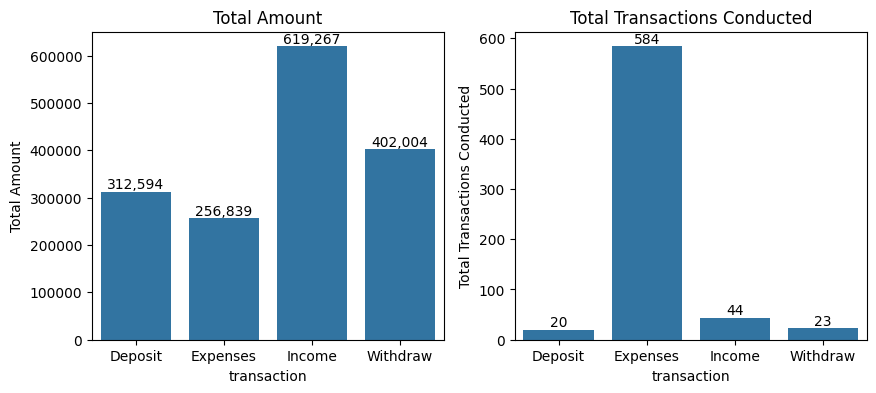

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))                       #<- Setting figure size for bar plot

# Bar Plotting the Data
for idx, col in enumerate(transactions.columns):                    #<- Iterating through columns of transactions DataFrame
    trans = sns.barplot(data=transactions[col], ax=ax[idx])         #<- Bar plot
    for bar in trans.patches:                                       #<- Data labels
        height = bar.get_height()

        if height > 0:
            trans.text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', va='bottom', ha='center')
    trans.set_title(col)

transactions

### Descriptive Interpretation
- So far, the **highest recorded total amount is the Income category**.
    - Total amount of $\text{Php}\: 619,267$ of gross income.
    - If Expenses category is higher than Income, it could mean I am spending more than earning.

- So far, the **highest recorded transaction is the expenses category**.
    - Total of $584$ recorded transactions.

### **Analyzing Net Income**
Columns involve:
- `'transaction'`
- `'y/m'`
- `'month sort no.'`

In [8]:
test_month_sort = df[['y/m', 'month sort no.']].set_index('y/m').to_dict()['month sort no.'] #<- Creating a dictionary for month sorting based on 'y/m' and 'month sort no.' columns
test_df = df[(df['transaction'] == 'Income') | (df['transaction'] == 'Expenses')]           #<- Filtering DataFrame for 'Income' and 'Expenses' transactions
test_piv = test_df.pivot_table(index='y/m',                                                 #<- Pivoting the DataFrame to have 'y/m' as index
                               columns='transaction', 
                               values='amount', 
                               aggfunc='sum').reset_index().dropna(subset=['Expenses'])

test_piv['month_sort'] = test_piv['y/m'].map(test_month_sort)                               #<- Mapping month sort to pivot table DataFrame
test_piv = test_piv.set_index('month_sort').sort_index()                                    #<- Setting index to 'month_sort' and sorting the DataFrame
test_piv['Net'] = test_piv['Income'] - test_piv['Expenses']                                 #<- Calculating Net Income
test_piv

transaction,y/m,Expenses,Income,Net
month_sort,,,,
2,23/11,10181.0,70026.0,59845.0
3,23/12,32023.0,43465.0,11442.0
4,24/1,9647.0,25466.0,15819.0
5,24/2,17583.0,25195.0,7612.0
6,24/3,18789.0,25195.0,6406.0
7,24/4,16059.0,32231.0,16172.0
8,24/5,12242.0,52230.0,39988.0
9,24/6,20411.0,25231.0,4820.0
10,24/7,21985.0,30278.0,8293.0


Mean Net Income = Php 21,273.87
Median Net Income = Php 15,819.00


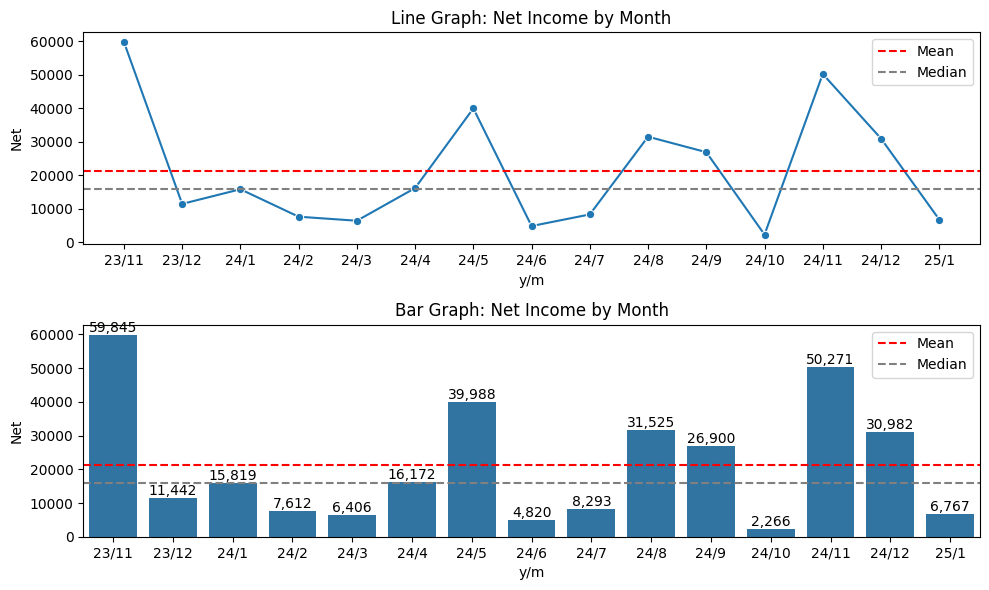

In [9]:
plot_line_bar(dataset=test_piv, x='y/m', y='Net', plot_title='Net Income by Month')  #<- Plotting Net Income by Month

# Terminal Output
print(f'Mean Net Income = Php {test_piv['Net'].mean():,.2f}')
print(f'Median Net Income = Php {test_piv['Net'].median():,.2f}')

### Descriptive Interpretation:
- **All months have positive net income**.
    - Net income is the **amount of money left after subtracting all expenses from total income** over a specific period.
    - **All months have positive net income**.
        - Could mean I saved these remaining monthly balance.

- Seems like there are more months that have net income values around $1000$ net income.
    - Placing median line would be worth to try.
    - It is also worth to view the distributions of this data.

### Distribution of Monthly Net Income

Median = 15,819.0
MAD = 10,999.0
Skewness = 0.86
Kurtosis = -0.43
Mean-Median Gap = 0.26


count       15.000000
mean     21273.866667
std      17890.346355
min       2266.000000
25%       7189.500000
50%      15819.000000
75%      31253.500000
max      59845.000000
Name: Net, dtype: float64

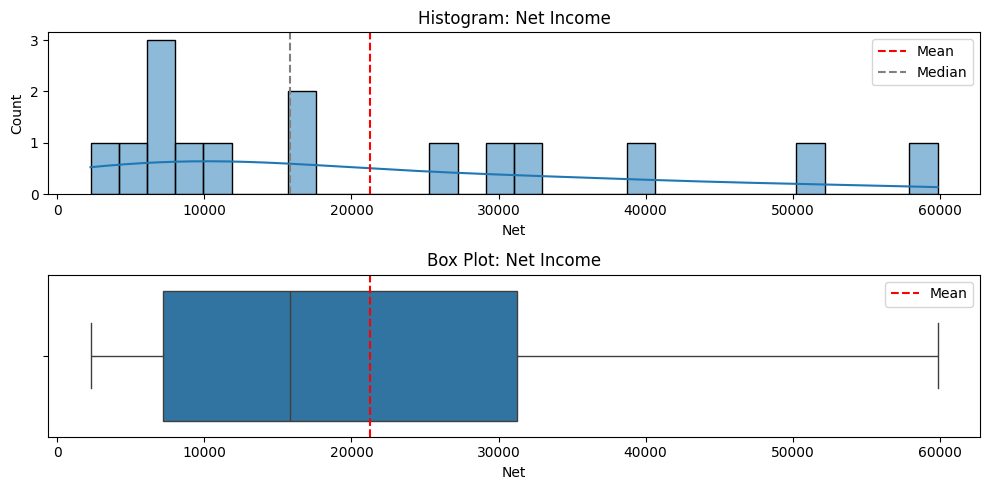

In [10]:
# Plotting Distribution of Net Income
plot_distribution(data=test_piv['Net'], plot_title='Net Income')    #<- Plotting distribution of Net Income

# Statistics Summary
stats_summary = StatsSummary(test_piv['Net'])                                   #<- Creating an instance of StatsSummary for Net Income
stats_summary.print_stats(mean=False, std=False,                                #<- Printing statistics summary for Net Income
                          median=True, mad=True, round_digit=2)
stats_summary.stat_summary

### Descriptive Interpretation:
- ⚠️**Skewness is $0.86$**.
    - **Distribution is mildly skewed to the right** (also called positively skewed).
    - It is beyond from 0 to 0.5 values to be considered as roughly normal.
    - Median central tendency would be better.
        - Mean is sensitive towards skews and outliers, resulting to misleading interpretation.
    - Parametric tests and confidence interval are not reliable in this kind of distribution.
        - Using non-parametric tests and bootstrap CI would be much reliable.

- ✅**Kurtosis is $-0.43$**.
    - The tailedness of the data.
        - $>0$ kurtosis.
            - Data can be present on the extremes.
            - Can distort mean and widens standard deviation.
            - Makes mean less reliable as central tendency of the data.
        - $<0$ kurtosis.
            - Data are more concentrated at the center value.
            - Less data on the extremes.
            - Sampling bias could be present if too far from 0.
    - $-0.43$ is between $0$ and $-1$.
        - **Can be safely say the distribution have light tails**.
            - There are no outliers on the data.

- 🚩**Mean-median gap is $26$%**.
    - The value is beyond $20$% to be considered as close together.
        - Mean is being pulled by non-typical data.
        - This **makes our mean to be less reliable as central tendency**.
            - Using **median as central tendency would be better and more reliable**.
            - Using non-parametric tests and bootstrap CI are safer route if inferences needed.

- **Median value is $\text{Php}\: 15,819$.**
    - The middle value of the data.
    - **Typically have monthly net income around $\text{Php}\: 15,819$**.

- **MAD (Median Absolute Deviation) value is $\text{Php}\: 10,999$.**
    - About how much the the net income varies in each month from the median.
    - This means **monthly net income may typically vary around $\text{Php}\: 10,999$ above or below $\text{Php}\: 15,819$.**

- **IQR is from $\text{Php}\: 7,189.5$ to $\text{Php}\: 31,253.5$.**
    - The range where 50% values (the half proportion) of the data lies.
    - In other words, the **typical monthly net income is between $\text{Php}\: 7,189.5$ to $\text{Php}\: 31,253.5$.**

- **In Summary:**
    - The data distribution is **mildly skewed to the right**
    - **Typically have monthly net income around $\text{Php}\: 15,819$**.
    - Monthly net income may **typically vary around $\text{Php}\: 10,999$** above or below $\text{Php}\: 15,819$.
    - **Typical monthly net income is between $\text{Php}\: 7,189.5$ to $\text{Php}\: 31,253.5$.**

## **`Expenses` transactions**
### Monthly Expenses

In [11]:
# Extracting `Expenses` and Make DF
df_expenses = df.loc[df['transaction'] == 'Expenses']

# Group by str `y/m` and Sum their Amount
grpby_expen_by_month = df_expenses.groupby('y/m')['amount'].sum().reset_index()             #<- Grouping by 'y/m' and summing the 'amount' for Expenses

grpby_expen_by_month['date sort no.'] = grpby_expen_by_month['y/m'].map(date_arrangement)   #<- Appending Date Sorting No. for sorting
grpby_expen_by_month = grpby_expen_by_month.sort_values(by='date sort no.')                 #<- Sorting by Date Sorting No.

grpby_expen_by_month

,y/m,amount,date sort no.
0,23/11,10181,2
1,23/12,32023,3
2,24/1,9647,4
6,24/2,17583,5
7,24/3,18789,6
8,24/4,16059,7
9,24/5,12242,8
10,24/6,20411,9
11,24/7,21985,10
12,24/8,11107,11


count       15.00
mean     17122.60
std       6503.81
min       9647.00
25%      11413.50
50%      17583.00
75%      20455.00
max      32023.00
Name: amount, dtype: float64

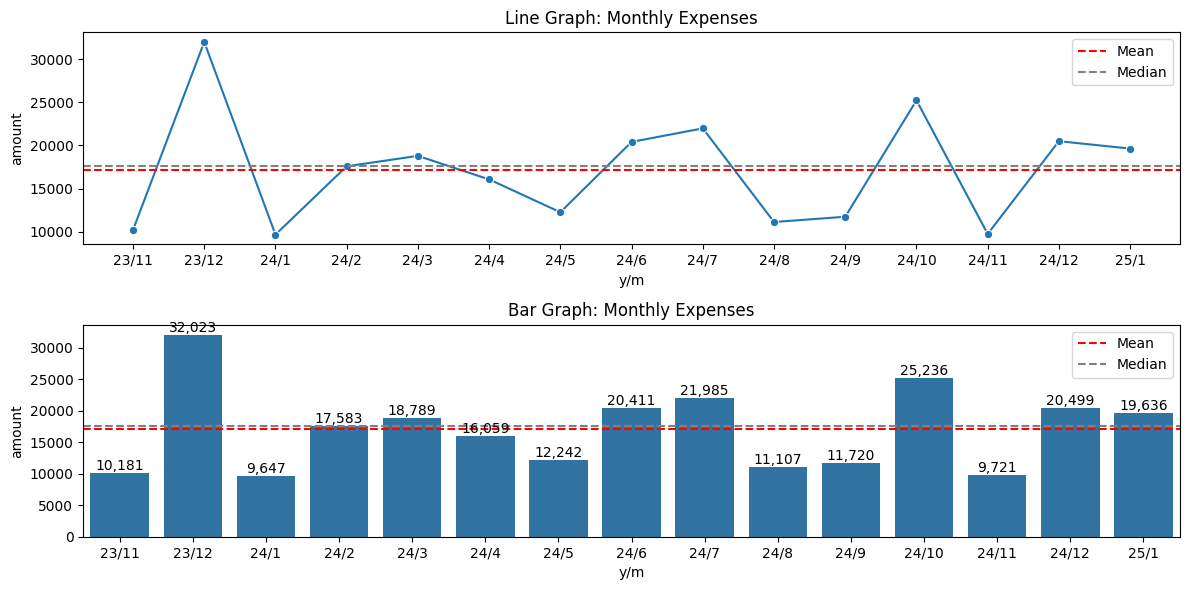

In [12]:
# Setting Mean, Median, and Standard Deviation of Monthly Expenses
stats_monthly_expen = StatsSummary(grpby_expen_by_month['amount'])

# Plotting Monthly Expenses
plot_line_bar(dataset=grpby_expen_by_month, x='y/m', y='amount', plot_title='Monthly Expenses', fig_size=(12, 6))  #<- Plotting Monthly Expenses

# Terminal Output
stats_monthly_expen.stat_summary.round(2)

### Descriptive Interpretation
- **Mean of $\text{Php}\: 17,122.6$.**
    - This means that the **average monthly expenses is $\text{Php}\: 17,122.6$.**

- **Standard deviation of $6,503.81$.**
    - The average variation monthly expenses if it is not equal to the mean, which is either greater than or less than the mean.
    - This means that the **average variation of monthly expenses is $\text{Php}\: 6,503.81$ either above or below $\text{Php}\: 17,122.6$.**

#### **Further Observations:**  
**Line Graph**
1. There are **less variation of monthly expenses from $\text{Feb.}\: 2024\: \text{(24/2)}$ to $\text{Jul.}\: 2024\: \text{(24/7)}$ from the mean**.
    - Are **data points that are not far from the mean line** (the red line).
    - This seems to be the more typical monthly expenses.
    - There have typical monthly expenditures.

2. There are **larger variation of monthly expenses from $\text{Nov.}\: 2023\: \text{(23/11)}$ to $\text{Jan.}\: 2024\: \text{(24/1)}$, and $\text{Oct.}\: 2024\: \text{(24/10)}$ to $\text{Mar.}\: 2025\: \text{(25/3)}$**.
    - Are **data points that are further from the mean line**.
    - The further from the line, the greater variation, the greater it contribution to increase standard deviation.
    - ***If data point is greater than the red line*** either: 
        - *There are greater expenses than usual in that month*, or 
        - *There are lesser than usual income in that month*.
    - ***If data point is less than the red line*** either:
        - *There are lesser expenses than usual in that month*, or
        - *There are greater income than usual in that month*.

**Bar Graph**
- The **highest monthly expenses on these months is $\text{Dec.}\: 2023\: \text{(23/12)}$**.
    - The **month's expenses is around $\text{Php}\: 32,000$**.
        - Almost as much as the double amount of the average monthly expenses.
    - Although, the $\text{Dec.}\: 2024\: \text{(24/12)}$ is just around $\text{Php}\: 20,500$.
        - 2024's Dec. is $36$% less than 2023's Dec in terms of monthly expenses.
    - Inspecting this specific months from the data table could help us understand the expenditure behaviour.

#### Inspecting Why $\text{Dec.}\: 2023$ is the Highest in Terms of Monthly Expenses.

,Total Amount,Count of Transactions
details,,
balay (nov),5000,1
battery,3600,1
hatag kanda mama,3000,1
SSD,2900,1
laptop keyboard,2600,1
Gasolina (nov),2100,1
Ebo Sweldo,1500,1
laptop upgrade labor,1500,1
medisina,1375,1


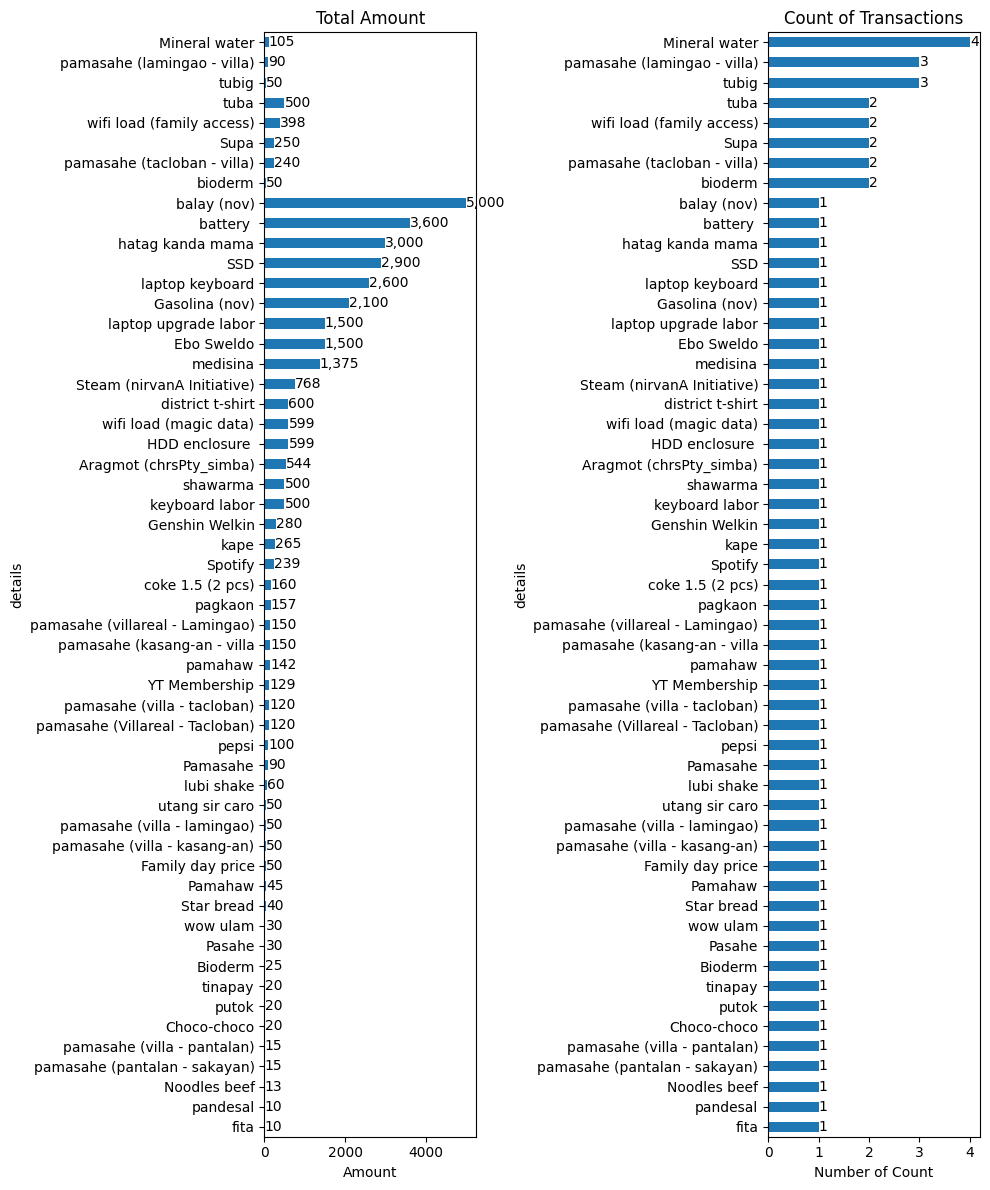

In [13]:
# Setting DataFrame for December 2023 Expenses Details
dec_2023_expen = df_expenses[df_expenses['y/m'] == '23/12']                                     #<- Filtering DataFrame for December 2023 expenses
grpby_dec2023 = dec_2023_expen.groupby('details')['amount'].agg(['sum', 'count']).sort_values(by=['count', 'sum'], ascending=True)  #<- Grouping December 2023 expenses by 'details' and summing the 'amount', also counting the number of transactions, then sorting by count and sum
grpby_dec2023.columns = ['Total Amount', 'Count of Transactions']                     #<- Renaming columns for clarity
x_axis = ['Amount', 'Number of Count']                                                          #<- X-axis labels for bar plot      

# Plotting Total Amount and Counts of Transactions for December 2023 Expenses
fig, ax = plt.subplots(1, 2, figsize=(10, 12))                                                  #<- Setting figure size for bar plot

for idx, col in enumerate(grpby_dec2023.columns):                                               #<- Iterating through columns of grouped DataFrame
    plt0 = grpby_dec2023.reset_index().plot(kind='barh', x='details', y=col, ax=ax[idx])        #<- Plotting bar graph for December 2023 expenses

    for bar in plt0.patches:                                                                    #<- Data labels
        height = bar.get_width()
        if height > 0:
            plt0.text(height, bar.get_y() + bar.get_height()/2, f'{height:,.0f}', va='center', ha='left')

    plt0.set_title(f"{col}")
    plt0.set_xlabel(x_axis[idx])                                                                #<- Setting x-axis label
    plt0.legend().set_visible(False)                                                            #<- Hiding legend for each subplot

plt.tight_layout()

# Terminal Output (Filtered and Sorted December 2023 Expenses Details)
grpby_dec2023[grpby_dec2023['Total Amount'] >= 1000].sort_values(by='Total Amount', ascending=False)  #<- Filtering and sorting December 2023 expenses details with total amount greater than 1000

### Descriptive Interpretation:
- On the filtered data table, it shows transaction in the month of $\text{Dec.}\: 2023$ that have greater than or equal to $\text{Php}\: 1000$ total amount.
    - The unsuals expenses are:
        - battery $(\text{Php}\: 3600)$
        - hatag kanda mama $(\text{Php}\: 3000)$
        - SSD $(\text{Php}\: 2900)$
        - laptop keyboard $(\text{Php}\: 2600)$
        - laptop upgrade labor $(\text{Php}\: 1500)$
        - medisina $(\text{Php}\: 1375)$
    - The **unusuals expenses are mostly from laptop repair and parts**.

#### We can safely say:
- **The expenses are higher in $\text{Dec.}\: 2023$ because of laptop repair and upgrade expenses**.

### **Monthly Expenses Distribution**

Mean = 17,122.6
Standard Deviation = 6,503.81
Skewness = 0.65
Kurtosis = -0.19
Mean-Median Gap = 0.03


count       15.000000
mean     17122.600000
std       6503.806147
min       9647.000000
25%      11413.500000
50%      17583.000000
75%      20455.000000
max      32023.000000
Name: amount, dtype: float64

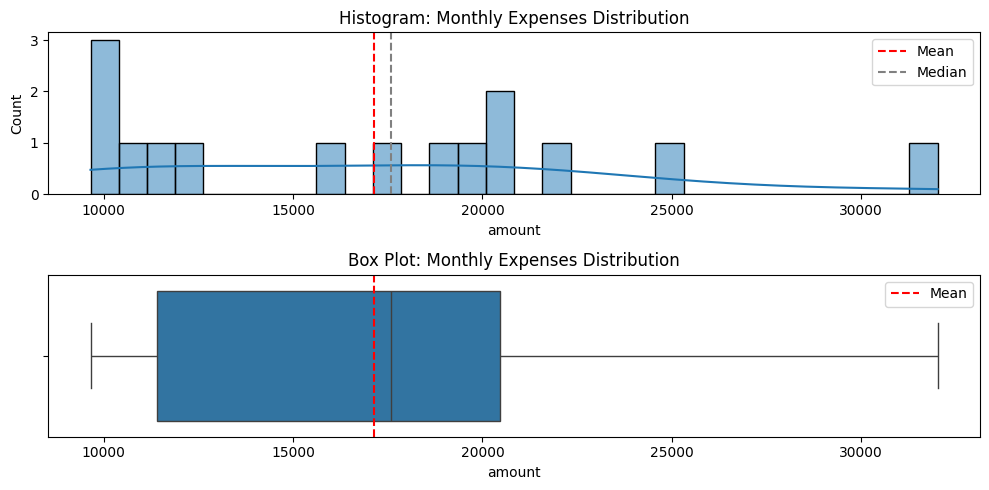

In [14]:
# Distribution Check with Distribution Plot
plot_distribution(data=grpby_expen_by_month['amount'], plot_title='Monthly Expenses Distribution')

# Terminal Output
stats_monthly_expen.print_stats(round_digit=2)  #<- Printing statistics summary for Monthly Expenses with rounding to 2 decimal places
stats_monthly_expen.stat_summary

### Descriptive Interpretation
- ⚠️**Skewness is $0.65$.**
    - The distribution is ** mildly skewed to the right**.
    - It is **beyond from $0$ to $0.5$** to be considered as roughly normal.

- ✅**Kurtosis is $-0.19$.**
    - It is between $0$ and $-1$ and much nearer to $0$.
        - The **tail of the distribution is roughly normal**.
            - The mean is not pulled much away by the data on the extremes.
            - The **mean and standard deviation of the data is still reliable dispite being mildly skewed**.

- ✅**Mean-median gap is $3$%.**
    - The gap is $<10%$, median is not distant to the mean.
        - This **further reinforces that mean is still reliable** as the distribution's central tendency.
    - Using parametric tests and CI in this data could still be reliable if inferences and modeling are needed.

- **Mean is $\text{Php}\: 17,123$**.
    - **Monthly expenses is around $\text{Php}\: 17,123$ on average.**

- **Standard Deviation is $\text{Php}\: 6,504$.**
    - The average variation of uncertainty from the mean.
    - **Monthly expenses may vary on average of $\text{Php}\: 6,504$ either above or below $\text{Php}\: 17,123$.**

- **IQR of $\text{Php}\: 11,414$ and $\text{Php}\: 20,455$.**
    - **It is not unusual to have monthly expenses around $\text{Php}\: 11,414$ and $\text{Php}\: 20,455$ in a typical month.**

- **In Summary:**
    - Mean and standard deviation are still reliable dispite the distribution's mild skewness.
        - Using parametric tests and CI in this data could still be reliable if inferences and modeling are needed.
    - **Monthly expenses is around $\text{Php}\: 17,123$ on average.**
    - **Monthly expenses may vary on average of $\text{Php}\: 6,504$ either above or below $\text{Php}\: 17,123$.**
    - **It is not unusual to have monthly expenses around $\text{Php}\: 11,414$ and $\text{Php}\: 20,455$ in a typical month.**

### Regression Plot

Text(0.5, 0, 'Months passes over time')

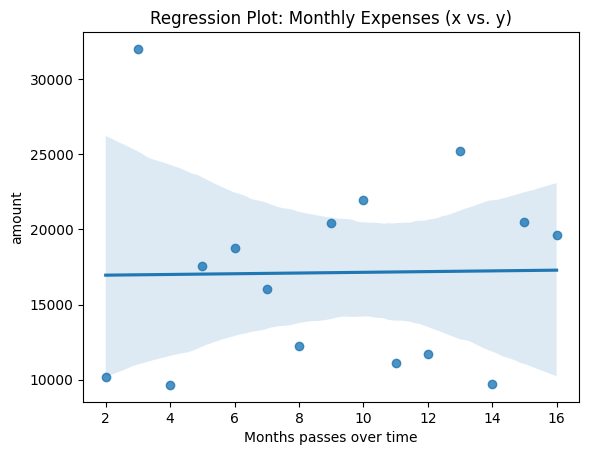

In [51]:
# Regression Plot
sns.regplot(data=grpby_expen_by_month, x=grpby_expen_by_month['date sort no.'], y='amount')
plt.title('Regression Plot: Monthly Expenses (x vs. y)')
plt.xlabel('Months passes over time')

### Linear Regression Test
Checking regression line's accuracy 
- Raw Linear regression

In [16]:
# Checking Regression Line's Accuracy
reg_expen = scistat.linregress(x=grpby_expen_by_month['date sort no.'], y=grpby_expen_by_month['amount'])  #<- Regression
slope_expen = reg_expen.slope               #<- slope (rate of change as x changes)
intercept_expen = reg_expen.intercept       #<- y-intercept

# Terminal Output
print(f"y = {slope_expen:.3f}x + {intercept_expen:.3f}")
print(f"R = {reg_expen.rvalue: .3f}")
print(f"R^2 = {reg_expen.rvalue ** 2: .4f}")

y = 23.768x + 16908.689
R =  0.016
R^2 =  0.0003


In [17]:
# Appending Predictions and Residuals for Better Data Visualization
y_pred = (grpby_expen_by_month['date sort no.'] * slope_expen) + intercept_expen    #<- y prediction calculation 
resid = grpby_expen_by_month['amount'] - y_pred                                     #<- Residuals calculation

grpby_expen_by_month['y pred'] = y_pred                                             #<- Appending y prediction
grpby_expen_by_month['resid'] = resid                                               #<- Appending residuals
grpby_expen_by_month

,y/m,amount,date sort no.,y pred,resid
0,23/11,10181,2,16956.225000,-6775.225000
1,23/12,32023,3,16979.992857,15043.007143
2,24/1,9647,4,17003.760714,-7356.760714
6,24/2,17583,5,17027.528571,555.471429
7,24/3,18789,6,17051.296429,1737.703571
8,24/4,16059,7,17075.064286,-1016.064286
9,24/5,12242,8,17098.832143,-4856.832143
10,24/6,20411,9,17122.600000,3288.400000
11,24/7,21985,10,17146.367857,4838.632143
12,24/8,11107,11,17170.135714,-6063.135714


Text(0, 0.5, 'Residuals')

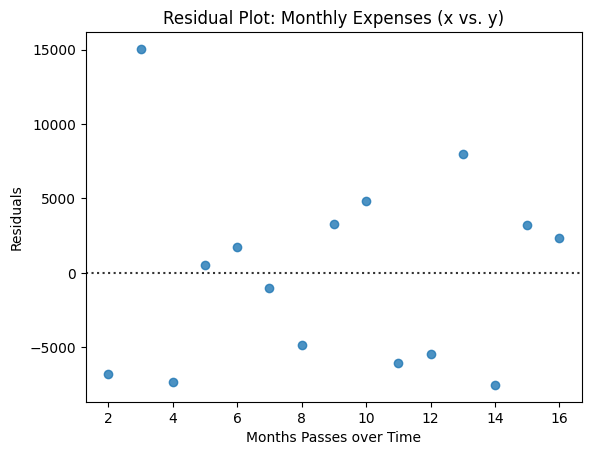

In [18]:
# Residual Plotting to Check How Scattered the Estimate Around the Model
sns.residplot(data=grpby_expen_by_month, x=grpby_expen_by_month['date sort no.'], y='resid')
plt.title('Residual Plot: Monthly Expenses (x vs. y)')
plt.xlabel('Months Passes over Time')
plt.ylabel('Residuals')

In [19]:
# Calculating RMSE, MAE and NRME
rmse = np.sqrt(np.sum(grpby_expen_by_month['resid']**2)/len(grpby_expen_by_month['resid']))
mae = np.sum(np.abs(grpby_expen_by_month['resid'])) / len(grpby_expen_by_month['resid'])
nrmse = rmse / stats_monthly_expen.mean

# Terminal Output
print('Summary of Descriptive Stats and Metric Calculation:')                                       #<- Descriptive Statistics
print(f" - Mean Monthly Expenses = {stats_monthly_expen.mean:.3f}")
print(f" - Standard Deviation of Monthly Expenses (std)= Php {stats_monthly_expen.std:.3f}")

print('\nRegression Metrics:')                                                                      #<- Regression Metrics
print(f" - R^2 = {reg_expen.rvalue ** 2: .3f}")
print(f" - Root Mean Square Error (RMSE) = {rmse:.3f}")
print(f" - Mean Absolute Error (MAE) = {mae:.3f}")
print(f" - mean-Normalized Root Mean Squarer Error (NRMSE) = {nrmse * 100:.2f}%\n")

print("Checking if RMSE < std:")                                                                    #<- Check RMSE vs std
print(f' - RMSE < std = {rmse:.3f} < {stats_monthly_expen.std:.3f} =  {rmse < stats_monthly_expen.std}')
print(f" - Percent difference = {(1 - (rmse/stats_monthly_expen.std)) * 100:.2f}%")                 #<- Percent difference between RMSE and std

Summary of Descriptive Stats and Metric Calculation:
 - Mean Monthly Expenses = 17122.600
 - Standard Deviation of Monthly Expenses (std)= Php 6503.806

Regression Metrics:
 - R^2 =  0.000
 - Root Mean Square Error (RMSE) = 6282.434
 - Mean Absolute Error (MAE) = 5208.315
 - mean-Normalized Root Mean Squarer Error (NRMSE) = 36.69%

Checking if RMSE < std:
 - RMSE < std = 6282.434 < 6503.806 =  True
 - Percent difference = 3.40%


### Model Metric Interpretation:
- ✅**RMSE is $3.4$% less than standard deviation.**
    - Translating how much uncertainty or error the model have compared to mean as an estimator.
    - The model have $3.4$% less error, therefore it is better than using the mean to predict a value.
    - $3.4$% is too small difference, it means **the model is barely better than using mean as an estimator**.

- ⚠️ **$R^2$ is $0$.**
    - The model explains nothing about the variance in expenses.
    - The **model isn't capturing any meaningful pattern at all**.

- ⚠️**NRMSE is approx. $36.69$%.**
    - Usually, $<10$% is considered excellent
        - $10–20$% is good, and 
        - $>30$% is considered poor prediction in many domains
    - The average prediction error is about $36.69$% of the target mean value.
    - This could mean that if the mean expenses is $\text{Php}\; 15,000$, then the **prediction is $\text{Php}\; 5,504$ off on average**, when accounting for large mistakes.

- ✅Residual Plot: Scattered Around the Model.
    - The model doesn't have clear structural bias.
    - The model doesn't misfitting the trend. 

#### **Overall Assessment:**
- **The model is barely better than using mean as an estimator**.
    - It is slightly reduced error compared to them mean as an estimator.
- Usable, but expect nothing when it comes to the precision. 
- Further feature exploration or alternative models are recommended.

## Data Transformation Attempt: x vs. log(y)
An attempt for exploring alternative predicting models.

,y/m,amount,date sort no.,y pred,resid,log
0,23/11,10181,2,16956.225000,-6775.225000,9.228279
1,23/12,32023,3,16979.992857,15043.007143,10.374210
2,24/1,9647,4,17003.760714,-7356.760714,9.174402
6,24/2,17583,5,17027.528571,555.471429,9.774688
7,24/3,18789,6,17051.296429,1737.703571,9.841027
8,24/4,16059,7,17075.064286,-1016.064286,9.684025
9,24/5,12242,8,17098.832143,-4856.832143,9.412628
10,24/6,20411,9,17122.600000,3288.400000,9.923829
11,24/7,21985,10,17146.367857,4838.632143,9.998116
12,24/8,11107,11,17170.135714,-6063.135714,9.315331


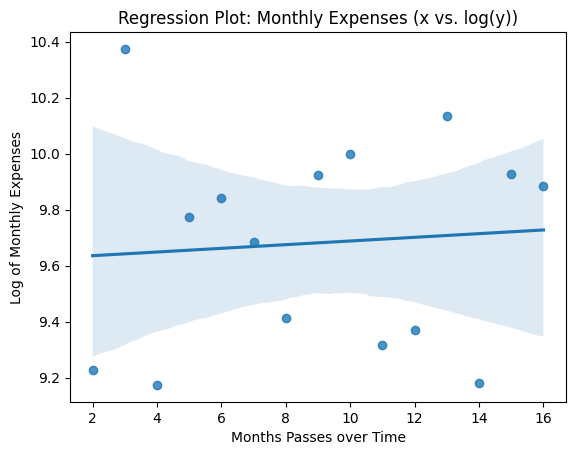

In [20]:
# Transforming Y with log() base 10
grpby_expen_by_month['log'] = np.log(grpby_expen_by_month['amount'])

# Scatter Plot Visulization with Approximate Linear Regression
sns.regplot(x=grpby_expen_by_month['date sort no.'], y=np.log(grpby_expen_by_month['amount']))
plt.title('Regression Plot: Monthly Expenses (x vs. log(y))')
plt.xlabel('Months Passes over Time')
plt.ylabel('Log of Monthly Expenses')

grpby_expen_by_month

In [21]:
# Modeling log(y)
model_monthly_expen = LinearRegression()
model_monthly_expen.fit(X=grpby_expen_by_month['date sort no.'].values.reshape(-1, 1), y=grpby_expen_by_month['log'])

log_y_coef = model_monthly_expen.coef_[0]               #<- Coefficient
log_y_intrcpt = model_monthly_expen.intercept_          #<- Intercept

print(f"y = e^({log_y_coef:.3f}x + {log_y_intrcpt:.3f})")        #<- Terminal Output (Transformed Model)

y = e^(0.007x + 9.623)


In [22]:
# Appending y Prediction from log and Its Residuals to the DataFrame
grpby_expen_by_month['y pred (log)'] = np.exp(log_y_coef * grpby_expen_by_month['date sort no.'] + log_y_intrcpt)   #<- Calc y predictions
grpby_expen_by_month['resid (log)'] = grpby_expen_by_month['amount'] - grpby_expen_by_month['y pred (log)']         #<- Appending

grpby_expen_by_month

,y/m,amount,date sort no.,y pred,resid,log,y pred (log),resid (log)
0,23/11,10181,2,16956.225000,-6775.225000,9.228279,15303.928761,-5122.928761
1,23/12,32023,3,16979.992857,15043.007143,10.374210,15404.672300,16618.327700
2,24/1,9647,4,17003.760714,-7356.760714,9.174402,15506.079019,-5859.079019
6,24/2,17583,5,17027.528571,555.471429,9.774688,15608.153284,1974.846716
7,24/3,18789,6,17051.296429,1737.703571,9.841027,15710.899488,3078.100512
8,24/4,16059,7,17075.064286,-1016.064286,9.684025,15814.322056,244.677944
9,24/5,12242,8,17098.832143,-4856.832143,9.412628,15918.425440,-3676.425440
10,24/6,20411,9,17122.600000,3288.400000,9.923829,16023.214121,4387.785879
11,24/7,21985,10,17146.367857,4838.632143,9.998116,16128.692610,5856.307390
12,24/8,11107,11,17170.135714,-6063.135714,9.315331,16234.865450,-5127.865450


Text(0, 0.5, 'Residuals (log)')

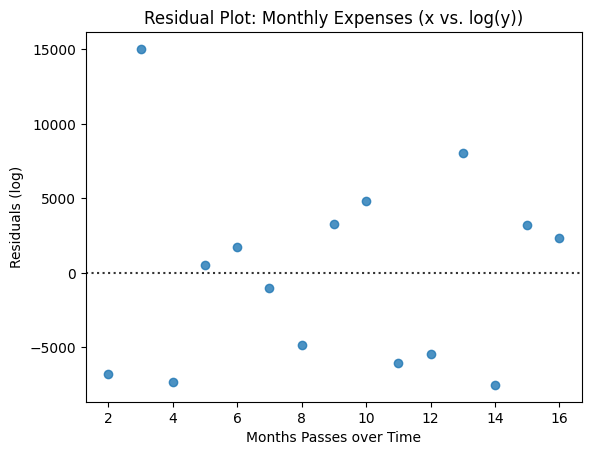

In [23]:
# Residual Plot of y Prediction
sns.residplot(x=grpby_expen_by_month['date sort no.'], y=grpby_expen_by_month['resid (log)'])
plt.title('Residual Plot: Monthly Expenses (x vs. log(y))')
plt.xlabel('Months Passes over Time')
plt.ylabel('Residuals (log)')

In [24]:
# Regression Metrics Calculation
r2_log_y = metrics.r2_score(y_true=grpby_expen_by_month['amount'], y_pred=grpby_expen_by_month['y pred (log)'])
rmse_log_y = metrics.root_mean_squared_error(y_true=grpby_expen_by_month['amount'], y_pred=grpby_expen_by_month['y pred (log)'])
nrmse_log_y = rmse_log_y/grpby_expen_by_month['amount'].mean()

# Storing Model Version to DataFrame
models_vers = {'Model Version': ['linereg_v1_raw', 'linereg_v2_log_y'],      #<- Storing model version to DataFrame
               'slope': [slope_expen, log_y_coef], 
               'intercept': [intercept_expen, log_y_intrcpt], 
               'R^2': [reg_expen.rvalue ** 2, r2_log_y],
               'RMSE': [rmse, rmse_log_y],
               'NRMSE': [nrmse, nrmse_log_y],
               'Note': ['Raw', 'x vs. log(y)']}  

model_ver_data = pd.DataFrame(models_vers)

# Terminal Output
print('Monthly Expenses Stats (Php):')              #<- Stats Summary
stats_monthly_expen.print_stats(round_digit=3, skew=False, kurtosis=False, mean_median_gap=False)  #<- Printing stats summary without skewness, kurtosis, and mean-median gap

print('\nRegression Metrics:')                      #<- Regression Metrics
print(f" - R^2 = {r2_log_y * 100:.2f}%")
print(f" - RMSE = {rmse_log_y:.2f}")
print(f" - NRMSE = {nrmse_log_y * 100:.2f}")

print('\nChecking RMSE vs. std')                    #<- Checking RMSE vs Std
print(f' - RMSE < std = {rmse_log_y:.3f} < {stats_monthly_expen.std:.3f} =  {rmse_log_y < stats_monthly_expen.std}')
print(f" - Percent difference = {(1 - (rmse_log_y/stats_monthly_expen.std)) * 100:.2f}%")                #<- Percent difference between RMSE and std

model_ver_data                                      # <- Displaying model version data

Monthly Expenses Stats (Php):
Mean = 17,122.6
Standard Deviation = 6,503.806

Regression Metrics:
 - R^2 = -3.30%
 - RMSE = 6385.96
 - NRMSE = 37.30

Checking RMSE vs. std
 - RMSE < std = 6385.960 < 6503.806 =  True
 - Percent difference = 1.81%


,Model Version,slope,intercept,R^2,RMSE,NRMSE,Note
0,linereg_v1_raw,23.767857,16908.689286,0.000267,6282.434488,0.366909,Raw
1,linereg_v2_log_y,0.006561,9.622742,-0.032953,6385.960103,0.372955,x vs. log(y)


### Model Metric Interpretation:
- 🚩 **$R^2$ is $-\text{3.3}%$.**
    - **Negative $R^2$ is worse than a flat mean guess.**
    - The model doesn't catch meaningful patterns of the data.

- ⚠️ **NRMSE is approximately $37.3$%.**
    - Larger than what we would want, which is $<30$%.
    - This could mean that if the average expenses is $\text{Php}\; 15,000$, then the **prediction is $\text{Php}\; 5,595$ off on average**, when accounting for large mistakes.

- ⚠️ **RMSE is $1.81$% less than standard deviation.**
    - The model have $1.81$% less average error than the mean have.
        - **The model is better than using mean as an estimator in terms of average prediction error**.
            - Though the mean catches more meaningful pattern of the data than the model does.
        - Though, $1.81$% difference away from mean is too small.
        - The model barely have less error than the mean.

- ✅Residual Plot: Scattered arount the model.
    - The model likely have no clear structural bias.
    - The model doesn't misfitting the trend.

### **Overall Assessment**
- It is better to use mean an estimator than this model.
- Though the model predicts less error, but it doesn't capture meaningful pattern of the data.
- The model seems to not show any bias.

## **Confidence Interval (CI)**
#### What is the true monthly expenses?

Mean = 17,122.6
Standard Deviation = 6,503.81
Skewness = 0.65
Kurtosis = -0.19
Mean-Median Gap = 0.03


count       15.000000
mean     17122.600000
std       6503.806147
min       9647.000000
25%      11413.500000
50%      17583.000000
75%      20455.000000
max      32023.000000
Name: amount, dtype: float64

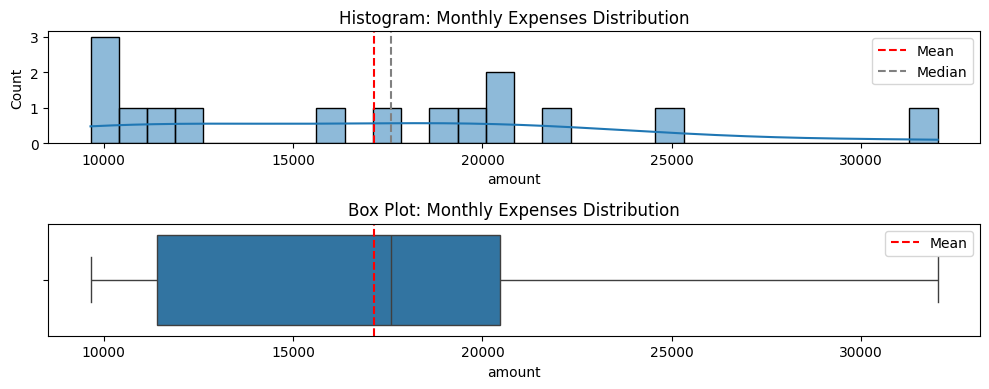

In [ ]:
# Distribution Check with Distribution Plot
plot_distribution(data=grpby_expen_by_month['amount'], plot_title='Monthly Expenses Distribution', fig_size=(10, 4))

# Terminal Output
stats_monthly_expen.print_stats(round_digit=2)
stats_monthly_expen.stat_summary

### **Estimating the True Monthly Expenses Average by Using Bootstrap Confidence Interval (CI)**
- The distribution can be assumed as normal in descriptive analysis, analysts should **analyze with caution when drawing inference**.
- Non-parametric CI, like **bootstrap, would be the safest route to avoid misleading inferences**.

In [56]:
# Bootstrap Confidence Interval
sample = np.random.choice(grpby_expen_by_month['amount'],                               #<- Random sampling simulation 
                          size=(10_000 , len(grpby_expen_by_month['amount'])), replace=True)
btsrp_means = sample.mean(axis=1)                                           #<- Mean of samples means

ci_lower = np.percentile(btsrp_means, ((1 - .95)/2) * 100)                  #<- Lower interval
ci_upper = np.percentile(btsrp_means, (1 - ((1 - .95)/2)) * 100)            #<- Upper interval

approx_moe = (ci_upper - ci_lower) / 2                                      #<- MOE approximation

# Terminal Output
print(f"95% Bootstrap CI:")
print(f" - Lower bound = {ci_lower:,.2f}")
print(f" - Upper bound = {ci_upper:,.2f}")

95% Bootstrap CI:
 - Lower bound = 14,058.45
 - Upper bound = 20,350.60


##### **Interpretation:**
- There's **$95$% confidence that the confidence interval procedure captures the true average monthly expenses**.
    - $95$% does not mean the chance of capturing.
    - It means if we sample from the population many times, then get the CI each of those trials, $95$% out of those trials will capture the true population mean.
- The **confidence interval is between $\text{Php}\: 14,058.45$ and $\text{Php}\: 20,350.6$**, where the true average lies.

### **Bootstrapping Visualization:**

Text(0.5, 0, 'Mean of Sample Means')

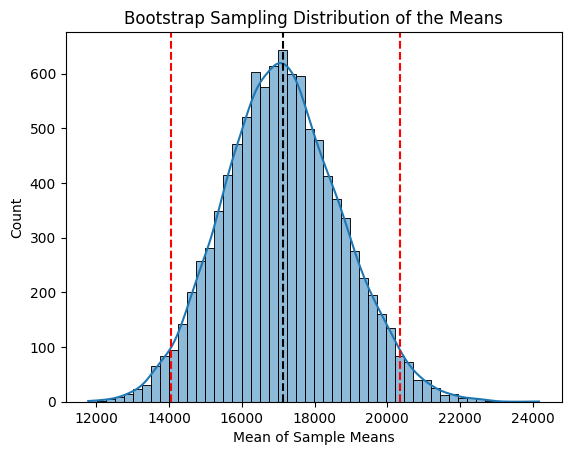

In [70]:
# Histogram Plotting
sns.histplot(btsrp_means, bins=50, kde=True)                    #<- Histogram setting
plt.axvline(btsrp_means.mean(), color='black', linestyle='--')  #<- Mean line (black)

for ci in [ci_lower,  ci_upper]:                                #<- CI line (red)
    plt.axvline(ci, color='red', linestyle='--')

plt.title('Bootstrap Sampling Distribution of the Means')
plt.xlabel('Mean of Sample Means')

### Giving Context on the Bootstrap Confidence Interval

In [82]:
# Comparing CI to Mean and Standard Deviation for Context
print(f"Mean = Php {stats_monthly_expen.mean:,.3f}")                                 #<- Mean
print(f"Standard Deviation = Php {stats_monthly_expen.std:,.3f}")         #<- Std
print(f"""\nBootstrap Confidence Interval (CI):                                                           
 - Lower Bound = Php {ci_lower:,.3f}
 - Upper Bound = Php {ci_upper:,.3f}\n""")                                                                     #<- CI

# Margin of Error
print('Margin of Error:')
print(f" - MOE = {approx_moe:,.3f}")                                          #<- MOE
print(f" - % of MOE against the Mean = {approx_moe / stats_monthly_expen.mean * 100:,.2f}%")                #<- MOE / mean
print(f" - % of MOE against the Standard Deviation = {approx_moe / stats_monthly_expen.std * 100: ,.2f}%")  #<- MOE / Std

Mean = Php 17,122.600
Standard Deviation = Php 6,503.806

Bootstrap Confidence Interval (CI):                                                           
 - Lower Bound = Php 14,058.445
 - Upper Bound = Php 20,350.603

Margin of Error:
 - MOE = 3,146.079
 - % of MOE against the Mean = 18.37%
 - % of MOE against the Standard Deviation =  48.37%


### Interpretation:
- 📝**Margin of Error is approximately $\text{Php}\: 3,146.079$:**
    - MOE says that we have that amount of **uncertainty either the true monthly expenses is $3,146.079$ below or above** from our average estimate.

- 👍**Relative MOE** $(\frac{\text{MOE}}{\text{mean}})$:
    - Tells us the precision of the CI by comparing its MOE against the mean.
    - Usually:
        - $< 5$% --> High precision
        - $5$% - $10$% --> Acceptable precision
        - $10$% - $20$% --> Moderate uncertainty
        - $> 20$% --> High uncertainty
    - There's **$18.37$% MOE against to mean**.
        - **Moderate uncertainty. Usable for personal finance tracking.**

- 👌 **CI width Against Standard Deviation $(\frac{\text{MOE}}{\text{std}})$:**
    - Tells us the overall spread (or noise) of MOE compared to standard deviation.
    - How informative or vague the estimate of CI.
    - Usually:
        - $< 20$% --> Excellent precision, and low variability.
        - $20$% - $50$% --> Moderate precision and variability.
        - $50$% --> CI is wide and has high variability.
    - There's **$48.37$% MOE against to standard deviation** (std).
        - **The CI has moderate precision but still meaningful.**

#### **Overall Assessment:**
- The CI has moderate uncertainty though still meaningful.
- The CI has moderate precision and variability.
- **The CI is comfortable enough to estimate the true monthly expenses average.**

# **Daily Expenses** 
`transaction` == `Expenses` and `amount`

In [29]:
# Setting Daily Expenses DataFrame
df_daily_expen = df_expenses.groupby('y/m/d')['amount'].sum().reset_index()

# Descriptive Statistics Summary
stats_daily_expen = StatsSummary(df_daily_expen['amount'])

# Terminal Output
print('Daily Expenses Statistic Summary (in Php):')
stats_daily_expen.print_stats(round_digit=3)

df_daily_expen

Daily Expenses Statistic Summary (in Php):
Mean = 1,156.932
Standard Deviation = 2,307.784
Skewness = 2.567
Kurtosis = 5.449
Mean-Median Gap = 0.793


,y/m/d,amount
0,23/11/10,73
1,23/11/13,162
2,23/11/14,25
3,23/11/15,125
4,23/11/16,55
...,...,...
217,25/1/15,2106
218,25/1/17,800
219,25/1/2,25
220,25/1/24,788


#### **Data Distribution Check**

Skewness: 2.567


,index,amount
0,count,222.000000
1,mean,1156.932432
2,std,2307.784252
3,min,5.000000
4,25%,125.000000
5,50%,239.000000
6,75%,691.000000
7,max,10360.000000


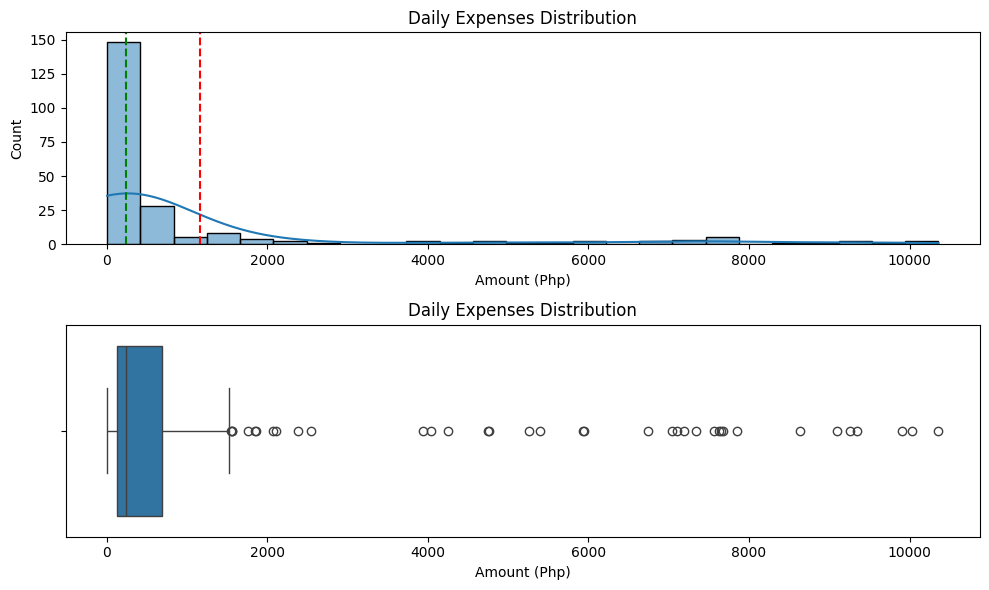

In [30]:
# Distribution Check Using Histogram and Boxplot in Subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Histogram
ax1 = sns.histplot(stats_daily_expen.data, kde=True, bins=25, ax=ax[0])               #<- Histogram Setting
ax1.set_title('Daily Expenses Distribution')                                            #<- Title
ax1.axvline(stats_daily_expen.mean, label='mean', color='red', linestyle='--')          #<- Mean line (red)
ax1.axvline(stats_daily_expen.median, label='median', color='green', linestyle='--')    #<- Median line (green)
ax1.set_xlabel('Amount (Php)')

# Boxplot
ax2 = sns.boxplot(x=stats_daily_expen.data, ax=ax[1])     #<- Boxplot Setting
ax2.set_title('Daily Expenses Distribution')              #<- Title
ax2.set_xlabel('Amount (Php)')                            #<- xlabel

plt.tight_layout()

# Terminal Output
print(f"Skewness: {scistat.skew(stats_daily_expen.data):.3f}")
stats_daily_expen.stat_summary.reset_index()

#### **Descriptive Interpretation**:
**Histogram**
- The distribution is skewed to the right.
    - **Usual daily expenses are less than 5000**, even 2500.
- The red vertical line is the mean of my daily expenses.
    - The average daily expenses, for over several days.
- The green vertical line is the **median of my daily expenses**.
    - It is the middle value of all data of my expenses.
    - It is **better daily expenses estimate** since the distribution is overly skewed to the right.

**Boxplot**
- The distribution is located to the left side of the plot.
    - The distribution is skewed to the left.
    - The box is where my most common daily expenses lands.
    - Narrow box means **consistently repeated data record**.
- There are many outliers in the distribution.
    - The **unusual daily expenses**.
    - Might need to transform this data for further inference.

## `Income` Analysis

In [31]:
# Extracting Income Data and Making Separate DF
df_income = df[df['transaction'] == 'Income']

# Group by `y/m` and Sum their Amount
grpby_income = df_income.groupby('y/m')['amount'].sum().reset_index()

map_month = df.loc[:, ['y/m', 'month sort no.']].drop_duplicates().set_index('y/m').to_dict()['month sort no.'] #<- Mapping dict
grpby_income['month sort no.'] = grpby_income['y/m'].map(map_month)                                             #<- Appeding mapping to Df
grpby_income = grpby_income.sort_values(by='month sort no.').set_index('month sort no.')                        #<- Sorting values

# Setting Stats Summary of Monthly Income
stats_monthly_income = StatsSummary(grpby_income['amount'])

grpby_income

,y/m,amount
month sort no.,,
0,23/9,17732
1,23/10,25588
2,23/11,70026
3,23/12,43465
4,24/1,25466
5,24/2,25195
6,24/3,25195
7,24/4,32231
8,24/5,52230


Monthly Income Statisitc Summary (in Php):
Mean = 36,427.471
Standard Deviation = 14,692.162
Median = 30,278.0
Skewness = 0.885
Kurtosis = -0.269
Mean-Median Gap = 0.169


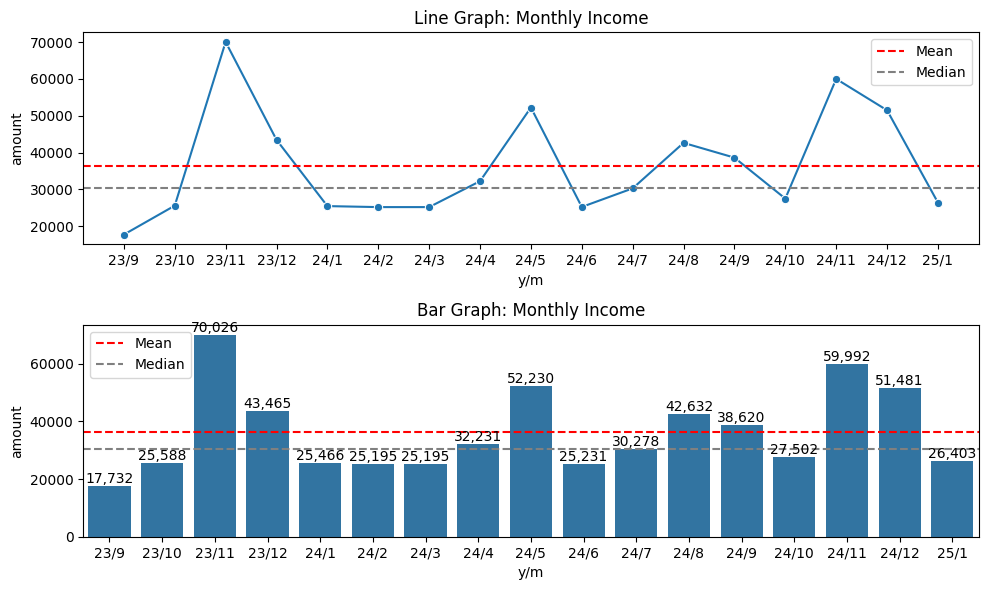

In [32]:
plot_line_bar(dataset=grpby_income, x='y/m', y='amount', plot_title='Monthly Income')  #<- Plotting Monthly Income

# Terminal Output
print("Monthly Income Statisitc Summary (in Php):")
stats_monthly_income.print_stats(median=True, round_digit=3)

#### **Descriptive Interpretation:**
**Line Graph**
- Income are at **highest during November and December** of the year.
    - Could be **caused by $13th$ month pay and other incentives**.
    - The same as on March. Can be because of mid-year bonus.
- February and March has 0 income.
    - Those are** months I no longer work** and **started to properly study about data analysis**.
- Because of these fluctuations, the monthly income has average variation of approximately $\text{Php}\;18,000$.

**Bar Graph**
- **Nov. of 2023, Nov.** and **Dec. of 2024** had higher income.
    - These are months where **there are some other source of income other than teaching**.
    - Might be the **reason why there's a large variation of monthly income**.

### **Monthly Income Distribution**

Skewness = 0.885


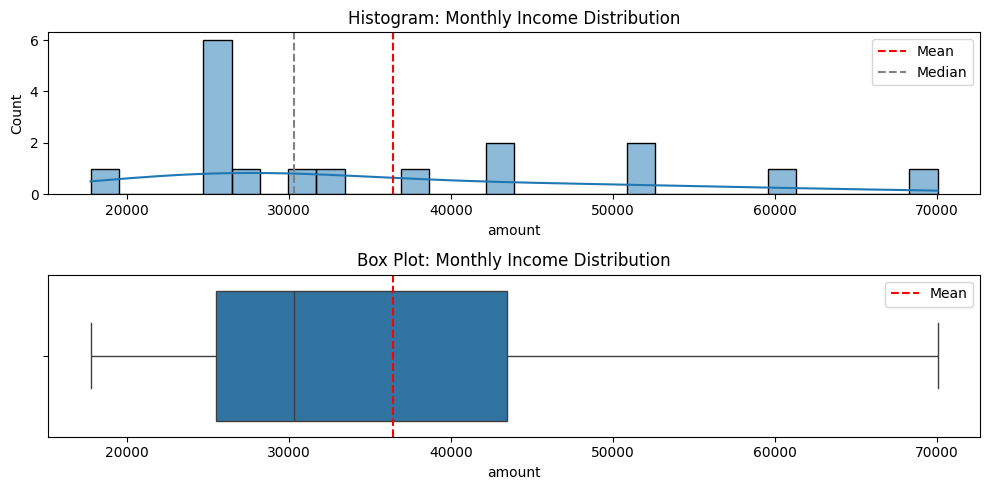

In [33]:
# Distribution Plot for Monlthy Income 
dict_data_income = {'Monthly Income Distribtion': stats_monthly_income.data}
plot_distribution(data=stats_monthly_income.data, plot_title='Monthly Income Distribution', skew=True)  #<- Plotting Monthly Income Distribution

#### **Descriptive Interpretation:**
- The distribution is **roughly normal**.
    - Skewness is **approximately 0.15**, almost 0, **safe to assume it is roughly normal**.

Text(0.5, 0, 'Month Passes over Time')

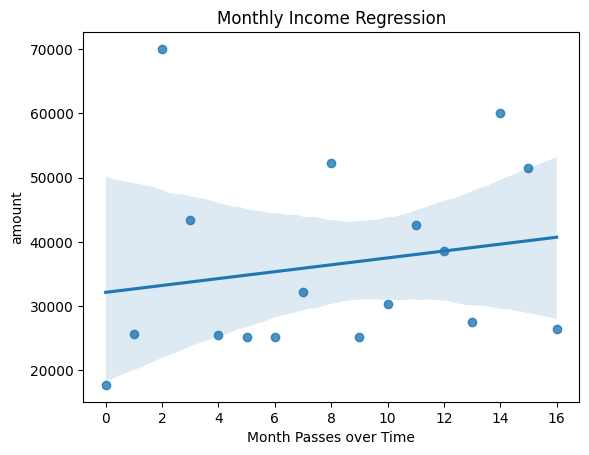

In [34]:
# Regression plot
sns.regplot(data=grpby_income, x=grpby_income.index, y='amount')
plt.title('Monthly Income Regression')
plt.xlabel('Month Passes over Time')

In [35]:
# Getting Slope and Intercep Value of Regression Line
reg_income = scistat.linregress(x=grpby_income.index, y=grpby_income['amount']) #<- Reg. line
slope_income = reg_income.slope                 #<- slope
intercept_income = reg_income.intercept         #<- y-intercept

# Terminal Output
print(f"y = {slope_income:.3f}x + {intercept_income:.3f}")
print(f"R = {reg_income.rvalue:.3f}")
print(f"R^2 = {reg_income.rvalue **2 :.3f}")

y = 536.012x + 32139.373
R = 0.184
R^2 = 0.034


In [36]:
# Amount Estimate and Residual Calcualtion
y_pred = (grpby_income.index * slope_income) + intercept_income   #<- Monthly income amount esimate
resid = grpby_income['amount'] - y_pred                         #<- Residuals

# Appending Monthly Amount Income Estimate and Residuals
grpby_income['y pred'] = y_pred     #<- Monthly Amount Income
grpby_income['resid'] = resid       #<- Residuals
grpby_income

,y/m,amount,y pred,resid
month sort no.,,,,
0,23/9,17732,32139.372549,-14407.372549
1,23/10,25588,32675.384804,-7087.384804
2,23/11,70026,33211.397059,36814.602941
3,23/12,43465,33747.409314,9717.590686
4,24/1,25466,34283.421569,-8817.421569
5,24/2,25195,34819.433824,-9624.433824
6,24/3,25195,35355.446078,-10160.446078
7,24/4,32231,35891.458333,-3660.458333
8,24/5,52230,36427.470588,15802.529412


Text(0.5, 0, 'Months Passese over Time')

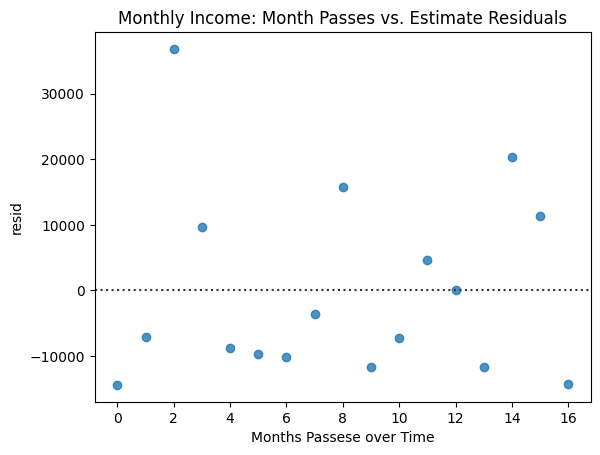

In [37]:
# Residual Plot
sns.residplot(x=grpby_income.index, y=grpby_income['resid'])
plt.title('Monthly Income: Month Passes vs. Estimate Residuals')
plt.xlabel('Months Passese over Time')

#### **Regression Metrics Assessment:**

In [38]:
# Regression Metrics Assessment
r2 = metrics.r2_score(y_true=grpby_income['amount'], y_pred=grpby_income['y pred'])
rmse = metrics.root_mean_squared_error(y_true=grpby_income['amount'], y_pred=grpby_income['y pred'])
mae = metrics.mean_absolute_error(y_true=grpby_income['amount'], y_pred=grpby_income['y pred'])
nrmse = rmse / stats_monthly_income.mean

# Terminal Output
print('Mean and Standard Deviation (Php):')                 #<- Mean and Std
stats_monthly_income.print_stats(round_digit=2)

print('\nRegression Metrics:')                              #<- Regression Metrics
print(f"- R^2 = {r2:.3f}")
print(f"- RMSE = {rmse:,.3f}")
print(f"- MAE = {mae:,.3f}")
print(f"- NRME = {nrmse:.3f}")

print('\nCheck RMSE < std:')                                #<- Check RMSE < std
print(f'- RMSE < std = {rmse < stats_monthly_income.std}')

Mean and Standard Deviation (Php):
Mean = 36,427.47
Standard Deviation = 14,692.16
Skewness = 0.89
Kurtosis = -0.27
Mean-Median Gap = 0.17

Regression Metrics:
- R^2 = 0.034
- RMSE = 14,009.517
- MAE = 11,603.482
- NRME = 0.385

Check RMSE < std:
- RMSE < std = True


### **Interpretation:**
- ✅RMSE is less than the Standard Deviation.
    - The **model is better than using the mean to predict** a value.
- ⚠️$R^2$ value is closer to 0 than 1.
    - The model only explains very little, and a large portion is unaccounted
    - The **model isn't capturing the real signal**.
- ⚠️NRMSE is approx. 58%.
    - The average prediction error is about 58% of the target mean value.
    - Since the mean income is $\text{Php}\; 32,600$, then the **prediction is $\text{Php}\; 18,850$ off on average**, when accounting for large mistakes.
- ✅Residual Plot: Scattered Around the Model.
    - The model doesn't have clear structural bias.
    - The model doesn't misfitting the trend. 

#### **Overall Assessment:**
- The **model is better than the mean** for estimation, but it is **not enough reason to safely rely in this model for precise prediction**.
- Usable, but expect nothing when it comes to the precision. 

## `G-cash` Transaction Mode

In [39]:
# Setting Gcash Expenses DataFrame
df_gcash = df[df['transaction_mode'] == "G-cash"]                       #<- Filtering Gcash only transactions
df_gcash_expen = df_gcash[df_gcash['transaction'] == 'Expenses']        #<- Filtering expenses only in gcash transactions

gcash_monthly_expen = df_gcash_expen.groupby('y/m')['amount'].sum().reset_index()   #<- Grouping by month

gcash_monthly_expen['month sort no.'] = gcash_monthly_expen['y/m'].map(map_month)   #<- Mapping by month
gcash_monthly_expen = gcash_monthly_expen.sort_values(by='month sort no.')          #<- Sorting by month

# Setting Summary Stat of Gcash Monthly Expenses
stats_gcash_expen = StatsSummary(gcash_monthly_expen['amount'])                             #<- Stats Summary Gcash expenses

# Terminal Output
gcash_monthly_expen

,y/m,amount,month sort no.
0,23/11,1003,2
1,23/12,2663,3
2,24/1,1957,4
5,24/2,2692,5
6,24/3,1746,6
7,24/4,2246,7
8,24/5,1970,8
9,24/6,2998,9
10,24/7,2903,10
11,24/8,1762,11


Skewness = -0.675
Summary Statistics: 
count      13.000000
mean     1961.846154
std       782.393214
min       199.000000
25%      1746.000000
50%      1957.000000
75%      2663.000000
max      2998.000000
Name: amount, dtype: float64


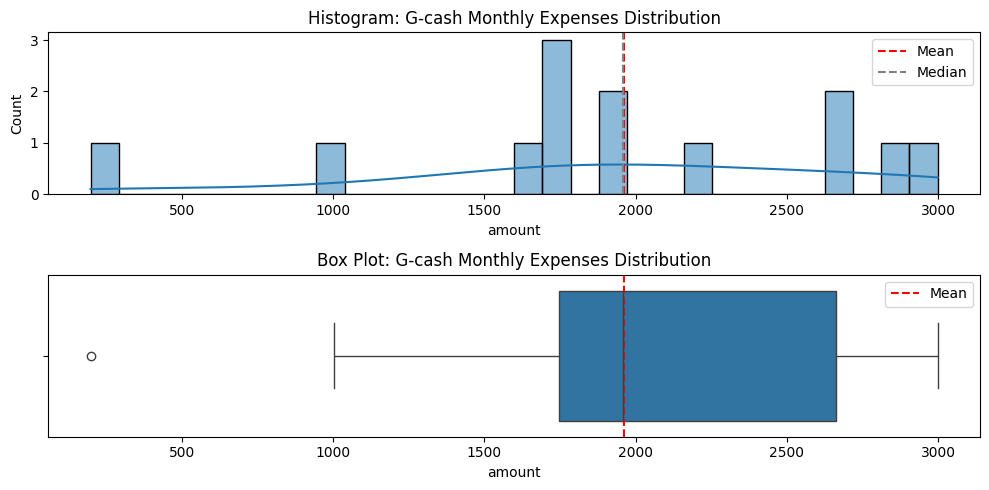

In [40]:
plot_distribution(data=gcash_monthly_expen['amount'], plot_title='G-cash Monthly Expenses Distribution', skew=True)  #<- Plotting Gcash Monthly Expenses Distribution

print(f"Summary Statistics: \n{stats_gcash_expen.stat_summary}")

### **Descriptive Interpretation**
- The distribution is **skewed to the left**.
    - Indicated by approximately **-0.68 skewness**.
    - Total monthly expenses **between 1,700 to 2,700 becames the "usual" range** of monthly expenses.
    - There is an average variation of ~Php 800 of monthly expenses.

#### **G-cash Expenses Data Plotting**

Mean and Standard Deviation of G-cash Monthly Expenses (Php):
Mean = 1,961.85
Standard Deviation = 782.39
Skewness = -0.68
Kurtosis = 0.13
Mean-Median Gap = 0.0


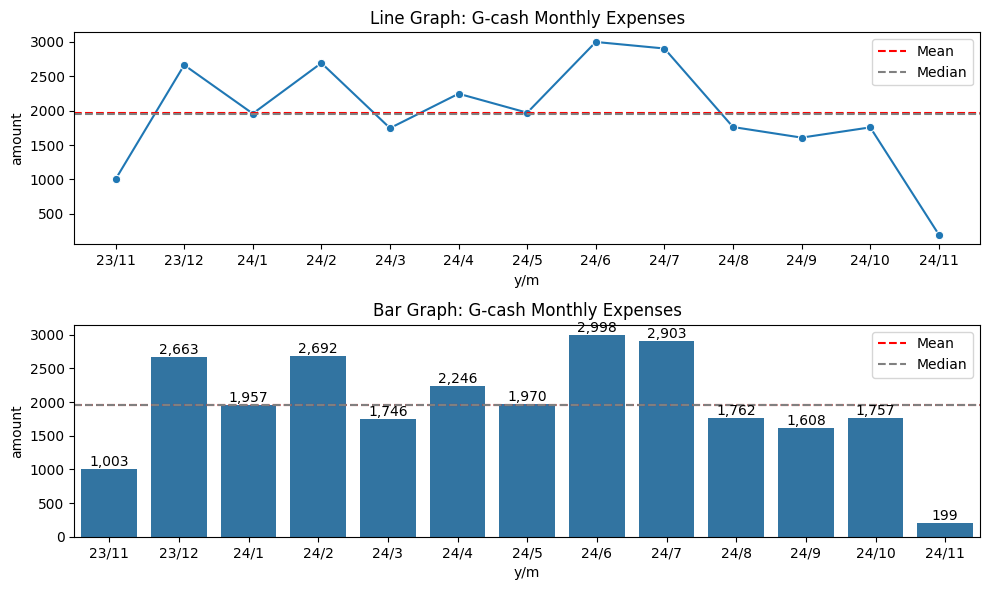

In [41]:
plot_line_bar(dataset=gcash_monthly_expen, x='y/m', y='amount', plot_title='G-cash Monthly Expenses')  #<- Plotting Gcash Monthly Expenses

# Terminal Output
print('Mean and Standard Deviation of G-cash Monthly Expenses (Php):')
stats_gcash_expen.print_stats(round_digit=2)

### **Grouping by G-cash Transactions** (Monthly)

In [42]:
# Grouping by Monthly Expenses Transactions
gcash_monthly_transac_expen = df_gcash_expen.groupby(['detail_clean', 'y/m'])['amount'].agg(['sum', 'mean', 'count']).reset_index()

# Aggregating Grouped by G-cash Monthly Expenses Transactions
aggr_gcash_month_trans_expen = gcash_monthly_transac_expen.groupby(['detail_clean'])['sum'].agg(['mean', 'std', 'median', 'count', 'sum']).reset_index()
aggr_gcash_month_trans_expen

,detail_clean,mean,std,median,count,sum
0,Genshin Welkin,280.000000,0.000000,280.0,7,1960
1,Membership gift,258.000000,NaN,258.0,1,258
2,Palaman peanut,500.000000,NaN,500.0,1,500
3,Sheena,150.000000,NaN,150.0,1,150
4,Spotify,235.250000,12.990381,239.0,12,2823
5,Steam,341.000000,332.231847,188.0,5,1705
6,Supa,512.833333,353.629193,377.0,12,6154
7,YT Membership,129.000000,0.000000,129.0,10,1290
8,YT sticker,15.000000,NaN,15.0,1,15
9,bag,1000.000000,NaN,1000.0,1,1000


In [43]:
# Setting DataFrame for Mean per Purchase Months, Monthly Total Expenses, and Expected Monthly Cost 
num_of_months = df_gcash_expen['y/m'].nunique()     #<- Number of Months (earliest record to latest)

others = aggr_gcash_month_trans_expen[aggr_gcash_month_trans_expen['count'] < 2]        #<- Empty amount list for <1 transaction count
regulars = aggr_gcash_month_trans_expen[aggr_gcash_month_trans_expen['count'] >= 2]     #<- Empty total expenses list for <1 transaction count

clean_df_gcash = regulars.loc[:, ['detail_clean', 'mean', 'sum', 'count']]              #<- Filtering "regulars" DataFrame
clean_df_gcash.sort_values(by='sum', ascending=False)

,detail_clean,mean,sum,count
6,Supa,512.833333,6154,12
14,wifi load (magic data),642.000000,4494,7
13,wifi load (family access),361.909091,3981,11
4,Spotify,235.250000,2823,12
0,Genshin Welkin,280.000000,1960,7
5,Steam,341.000000,1705,5
7,YT Membership,129.000000,1290,10


In [44]:
# Cleaning and Filtering "others"  
dict_others_gcash = others.loc[:, 'sum'].describe().to_dict()                                   #<- Setting "others" dict
df_others_gcash = pd.DataFrame([{'detail_clean': 'Others', 'mean': dict_others_gcash['mean'],   #<- Setting "others" to DataFrame
                           'sum': others['sum'].sum(), 'count': dict_others_gcash['count']}])

# Appending "others" to "regulars" Df
if df_others_gcash['detail_clean'][0] not in clean_df_gcash['detail_clean'].to_list():          #<- Avoids appending duplicate
    clean_df_gcash2 = pd.concat([clean_df_gcash, df_others_gcash], ignore_index=True)           #<- Appending "others" to "regulars"

# Renaming Columns and Appending Expected Monthly Cost
clean_df_gcash2.columns = ['details', 'mean per purchase months', 'total expenses', 'transaction count']
clean_df_gcash2['E(monthly cost)'] = clean_df_gcash2['total expenses'] / num_of_months

clean_df_gcash2

,details,mean per purchase months,total expenses,transaction count,E(monthly cost)
0,Genshin Welkin,280.000000,1960,7.0,150.769231
1,Spotify,235.250000,2823,12.0,217.153846
2,Steam,341.000000,1705,5.0,131.153846
3,Supa,512.833333,6154,12.0,473.384615
4,YT Membership,129.000000,1290,10.0,99.230769
5,wifi load (family access),361.909091,3981,11.0,306.230769
6,wifi load (magic data),642.000000,4494,7.0,345.692308
7,Others,387.125000,3097,8.0,238.230769


Number of Months Recorded (from earliest to lates) = 13 Months


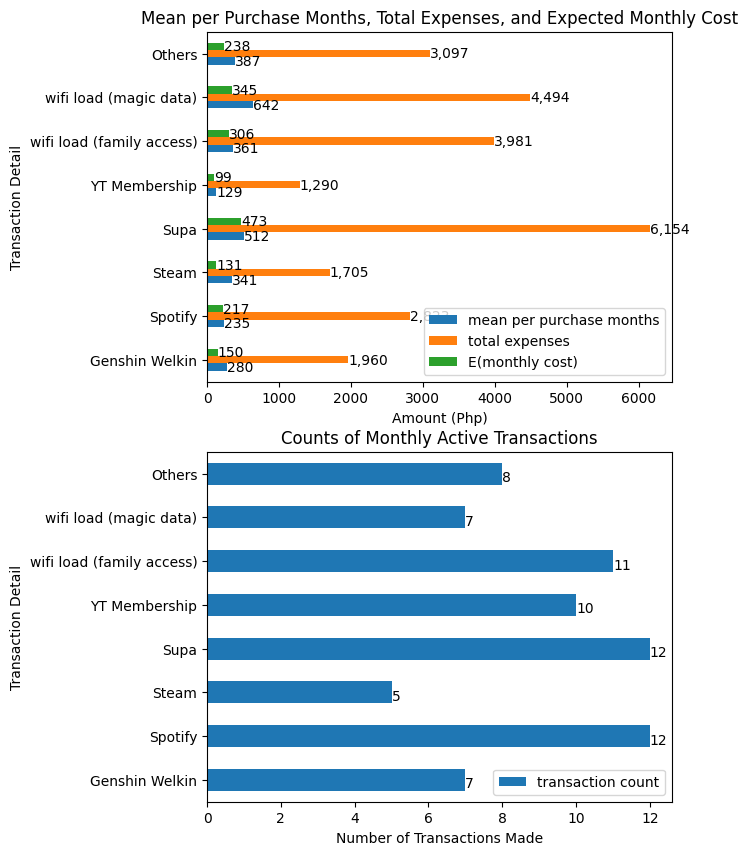

In [45]:
# Data Visualization for Mean per Purchase Months, Total Expenses, and Expected Monthly Cost
fig, ax = plt.subplots(2, 1, figsize=(6, 10))

# Horizontal Bar Plot of Mean per Purchase Months and Expected Monthly Cost
ax0 = clean_df_gcash2.plot(kind='barh', x='details', y=['mean per purchase months', 'total expenses', 'E(monthly cost)'], ax=ax[0])
for bar in ax0.patches:
    width = bar.get_width()
    ax0.text(x=width, y=bar.get_y() - bar.get_height()/2, s=f'{int(width):,}', va='bottom', ha='left')
ax0.set_xlabel('Amount (Php)')
ax0.set_ylabel('Transaction Detail')
ax0.set_title('Mean per Purchase Months, Total Expenses, and Expected Monthly Cost')

# Horizontal Bar Plot of Expected Monthly Cost
ax1 = clean_df_gcash2.plot(kind='barh', x='details', y='transaction count', ax=ax[1])
for bar in ax1.patches:
    width = bar.get_width()
    ax1.text(x=width, y=bar.get_y(), s=f'{int(width):,}', va='bottom', ha='left')
ax1.set_xlabel('Number of Transactions Made')
ax1.set_ylabel('Transaction Detail')
ax1.set_title('Counts of Monthly Active Transactions')

# Terminal Output
print(f"Number of Months Recorded (from earliest to lates) = {num_of_months} Months")

### **Descriptive Interpretation:**
##### **Total Expenses**  
- The total expenses recorded from its first record to latest.
- **"Supa" has the highest expenditure recorded amount** up to date.

##### **Mean of Purchase Months**  
- Average monthly active purchases.
- Compuation does not include months where there's no purchases.
    - "Supa" has approximately $\text{Php}\: 5,000$ average monthly active expenses.

##### **Expected Monthly Cost**
- An **amount where expenses approaches as number of attempts increases**.
- Might be lower than the mean of purchase months since it includes months where it spends nothing (zero purchase) in the computation.
- "Others" has large variation of expenses amount, but knowing the expected monthly expenses could lessen the uncertainty.
    - **"Others" expenses will be around $\text{Php}\: 240$ next month**.

##### **Transaction Counts**
- Counts of how many months we have recorded of spending (at least once in a month).
    - Buying a wifi load ***once*** in a given month will count as ***1 active month*** of spending.
    - Buying a wifi load ***twice*** in a given month will still count as ***1 active month*** of spending.
    - Buying ***not even once*** in a given month ***won't count as an active month*** of spending.
    - There are **60+ times I bought "Supa" throughout the record**, but **12 months are considered active**, since I bought it at least once a month.
- **I spend "Supa" and "Spotify" almost every month**.
    - One of the most frequent monthly purchases.

# **Hypothesis Testing**
### **Question 1:**  
#### Is it unusual to to have less than or equal to $\text{Php}\: 10,000$ monthly expenses?

$H_0:$ **Not unusual** to have less than or equal to $\text{Php}\: 10,000$ monthly expenses.  
$H_A:$ **It is unusual** to have less than or equal to $\text{Php}\: 10,000$ monthly expenses.  
$\alpha = 0.05$

#### **Non-parametric Hypothesis Testing will be used**.
- The monthly expenses data is **not normally distributed**.

Skewness = 0.645


count       15.000000
mean     17122.600000
std       6503.806147
min       9647.000000
25%      11413.500000
50%      17583.000000
75%      20455.000000
max      32023.000000
Name: amount, dtype: float64

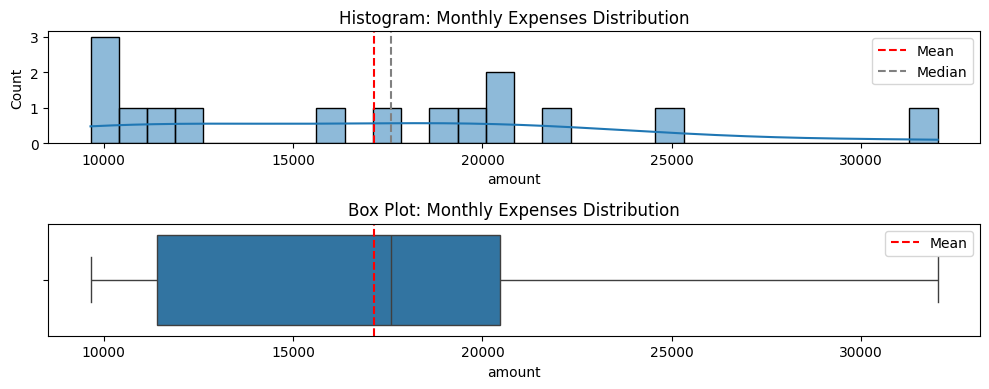

In [46]:
# Distribution Check with Distribution Plot
dict_data_expen = {'Monthly Expenses Distribution': grpby_expen_by_month['amount']}
plot_distribution(data=grpby_expen_by_month['amount'], plot_title='Monthly Expenses Distribution', skew=True, fig_size=(10, 4))

# Terminal Output
stats_monthly_expen.stat_summary

In [47]:
# Functions 
def interpret_pvalue(pvalue: float, alpha: float = 0.05) -> bool:
    """Checks if alpha (significance level) is less than the p-value (*default: 0.05*)."""

    if alpha < pvalue:
        print(f"Fail to Reject Null Hypothesis. alpha < p-value ({alpha} < {pvalue:.2f})")
    else:
        print(f"Reject Null Hypothesis. alpha > p-value ({alpha} > {pvalue:.2f})")


# Non-parametric Hypothesis Testing
assumed = 10_000                                                #<- Assumed number
diff = [x - assumed for x in grpby_expen_by_month['amount']]    #<- List of difference of data and assumed (x - assumed)
pos = sum(d > 0 for d in diff)                                  #<- Number of data ABOVE 0 difference
neg = sum(d < 0 for d in diff)                                  #<- Number of data BELOW 0 difference

n = pos + neg                                                   #<- Number of data EITHER below or above 0 difference
binom_result = scistat.binomtest(min(pos, neg), n=n, p=0.5, alternative='less')     #<- Binomial result

# Terminal Output
print(f'p-value: {binom_result.pvalue:.4f}\n')                  #<- p-value

print(f'Result:')
interpret_pvalue(binom_result.pvalue)                           #<- alpha vs. p-value

p-value: 0.0037

Result:
Reject Null Hypothesis. alpha > p-value (0.05 > 0.00)


#### **Interpretation:**
- Reject null hypothesis.
- There's **NOT enough evidence** to conclude that it is **NOT unsual** to have less than or equal to $\text{Php}\: 10,000$ monthly expenses.
- The data suggests that **it is unuasual** to have less than or equal to $\text{Php}\: 10,000$ monthly expenses.

### **Question 2:** 
##### When I started teaching, I have approximately $\text{Php}\: 21,000$ monthly salary (incentives not included). Does that amount is now unusual if I add up most incentives and after some changes of teacher's monthly salary from the start of my teaching career up until now?

$H_0:$ **Not unusual** to have $\text{Php}\: 21,000$ monthly income after some income changes.  
$H_A:$ **It is unusual** to have $\text{Php}\: 21,000$ monthly income after some income changes.  
$\alpha = 0.05$

##### **Parametric Hypothesis Testing will be used**
- Data distribution is **approximately normal** (skewness of ~0.147).
    - ✅Safe to assume **normality condition has been met**.
    - Though **need to check independence and random condition** to safely use parametric tests. 

Skewness = 0.885


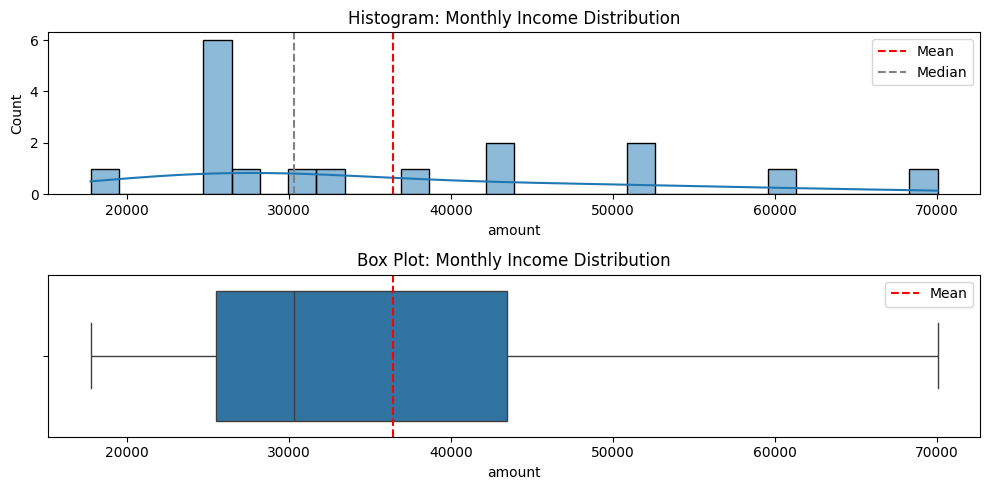

In [48]:
# Distribution Plot for Monlthy Income 
dict_data_income = {'Monthly Income Distribtion': stats_monthly_income.data}
plot_distribution(data=stats_monthly_income.data, plot_title='Monthly Income Distribution', skew=True)  #<- Plotting Monthly Income Distribution

Text(0.5, 1.0, 'Autocorrelation Plot of Monthly Income')

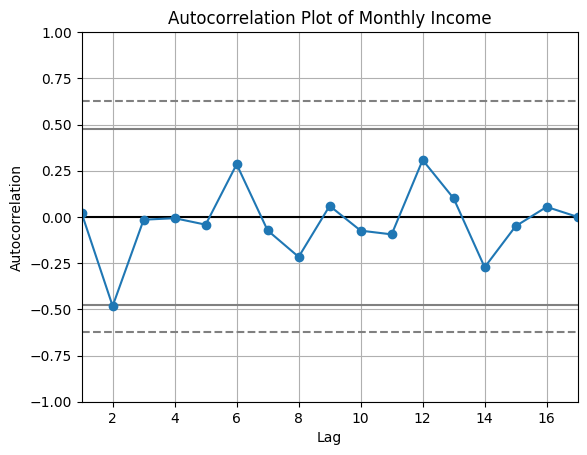

In [49]:
# Validating Independence and Random Condition via Autocorrelation Plot
pd.plotting.autocorrelation_plot(stats_monthly_income.data, marker='o')
plt.title('Autocorrelation Plot of Monthly Income')

### **Interpretation:**
- The plot tests whether the data values are correlated with their own past.
- Data points are not going beyong the border inside that spans from 0.
    - Meaning **data points are independent** from the previous data point.

✅**Independence:**
- Data are contained inside ~$\pm\; 0.49$.
- **Data points are independent** to prior data point.

✅**Randomness:**
- Data are independent in the plot.
- Randomness seems **statistically valid and justified**.

##### Hypothesis Testing:
- It is safe to assume that the **conditions of normality, independence, and randomness are met**.
- **Parametric hypothesis test would be safe to use**.
    - We'll use **1-sample t test**.

In [50]:
# 1-sample t test
confidence_lvl = 0.05

tstat, pvalue = scistat.ttest_1samp(a=stats_monthly_income.data, popmean=21_000)
print(f"p-value = {pvalue:.3f}")
print(f"Cofidence Level = {confidence_lvl}")

print('\nConclusion:')
interp_pvalue(p_value=pvalue, alpha=confidence_lvl)

p-value = 0.001
Cofidence Level = 0.05

Conclusion:
Reject Null Hypothesis. alpha < p-value is False


#### **Interpretation:**
- Reject null hypothesis.
- Data suggests that it is **likely unusual** to have $\text{Php}\: 21,000$ monthly income.
- There's **NOT enough evidence** to conclude that it is **NOT unusual** to have $\text{Php}\: 21,000$ monthly income.